In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-17 03:08:25.149765


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:1")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/mnist/vit_tiny"):
            os.makedirs("./best_params/mnist/vit_tiny")
        if acc >= best_acc:
            path = os.path.join("./best_params/mnist/vit_tiny", f"vit_tiny_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, label="Train Loss")
            plt.plot(x, y2, label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/mnist/vit_tiny/loss_curve"):
                os.makedirs("./best_params/mnist/vit_tiny/loss_curve")
            path = os.path.join("./best_params/mnist/vit_tiny/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4, padding_mode="edge"),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="./data",
                                       train=True,
                                       transform=transform_train,
                                       download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.MNIST(root="./data",
                                      train=False,
                                      transform=transform_test,
                                      download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

size= 1875
size= 313


# Load the model

In [7]:
from model_zoo.ViT import ViT_tiny_mnist
net = ViT_tiny_mnist()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:04:23.021316
Loss:1.4322418799034704


  0%|▍                                                                             | 1/200 [04:30<14:57:04, 270.48s/it]

Total:10000  Correct:4527  CleanAccuracy:0.4527
Epoch:1
Time:0:08:17.775590
Loss:1.0889316932461894
Total:10000  Correct:5831  CleanAccuracy:0.5831


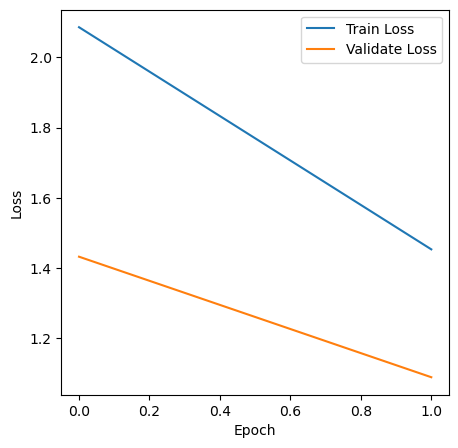

  1%|▊                                                                             | 2/200 [08:26<13:45:52, 250.27s/it]

Epoch:2
Time:0:12:14.886123
Loss:0.8966024422797912
Total:10000  Correct:6777  CleanAccuracy:0.6777


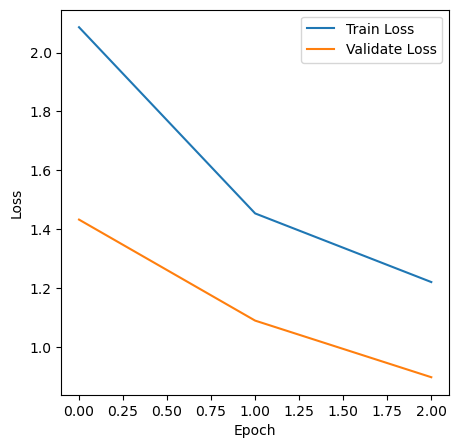

  2%|█▏                                                                            | 3/200 [12:23<13:21:50, 244.21s/it]

Epoch:3
Time:0:16:17.845459
Loss:0.6966166481994592
Total:10000  Correct:7642  CleanAccuracy:0.7642


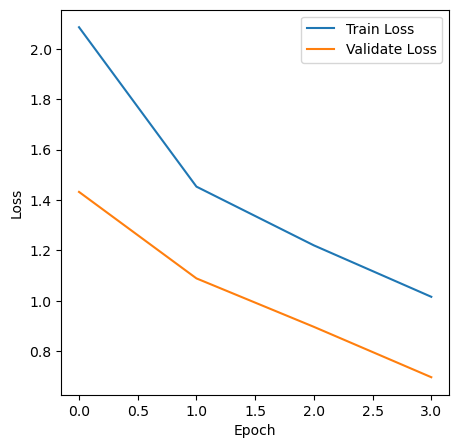

  2%|█▌                                                                            | 4/200 [16:26<13:16:07, 243.71s/it]

Epoch:4
Time:0:20:15.548239
Loss:0.745662463549227
Total:10000  Correct:7434  CleanAccuracy:0.7434


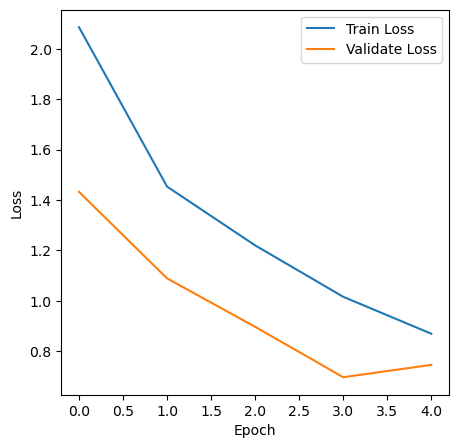

  2%|█▉                                                                            | 5/200 [20:24<13:04:56, 241.52s/it]

Epoch:5
Time:0:24:12.026082
Loss:0.4469514936922838
Total:10000  Correct:8560  CleanAccuracy:0.8560


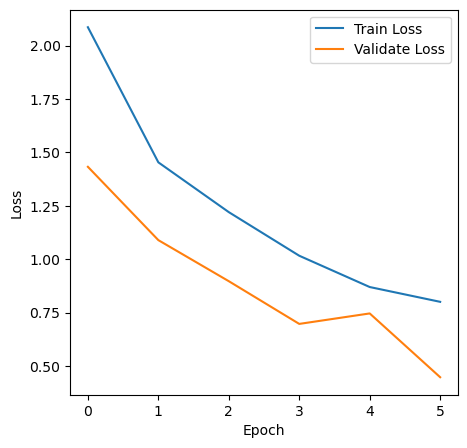

  3%|██▎                                                                           | 6/200 [24:20<12:55:28, 239.84s/it]

Epoch:6
Time:0:28:08.727649
Loss:0.5079551992086938
Total:10000  Correct:8344  CleanAccuracy:0.8344


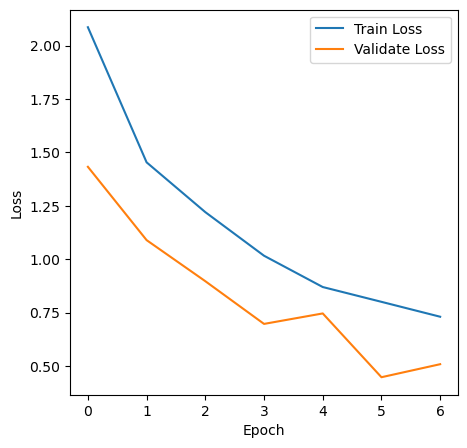

  4%|██▋                                                                           | 7/200 [28:17<12:48:01, 238.77s/it]

Epoch:7
Time:0:32:18.990582
Loss:0.332865922095867
Total:10000  Correct:9034  CleanAccuracy:0.9034


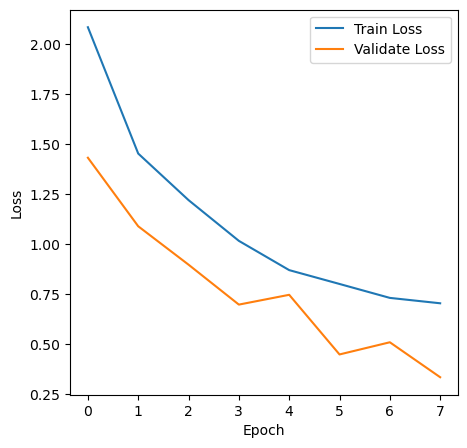

  4%|███                                                                           | 8/200 [32:27<12:55:48, 242.44s/it]

Epoch:8
Time:0:36:17.830244
Loss:0.4214019469036081
Total:10000  Correct:8648  CleanAccuracy:0.8648


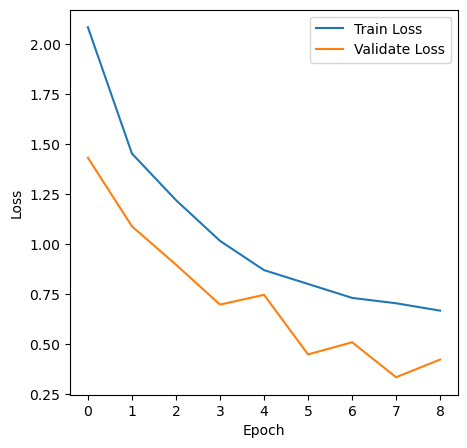

  4%|███▌                                                                          | 9/200 [36:26<12:48:07, 241.30s/it]

Epoch:9
Time:0:40:13.932069
Loss:0.40703459364918476
Total:10000  Correct:8763  CleanAccuracy:0.8763


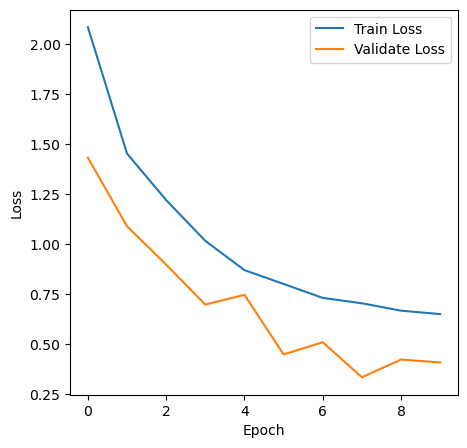

  5%|███▊                                                                         | 10/200 [40:22<12:38:43, 239.60s/it]

Epoch:10
Time:0:44:10.304081
Loss:0.3613313299398453
Total:10000  Correct:8831  CleanAccuracy:0.8831


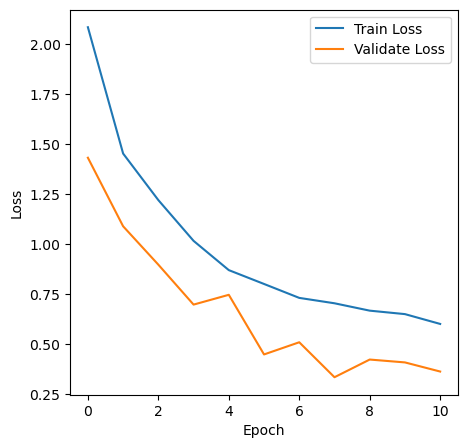

  6%|████▏                                                                        | 11/200 [44:18<12:31:58, 238.72s/it]

Epoch:11
Time:0:48:08.044455
Loss:0.32904440040786426
Total:10000  Correct:8903  CleanAccuracy:0.8903


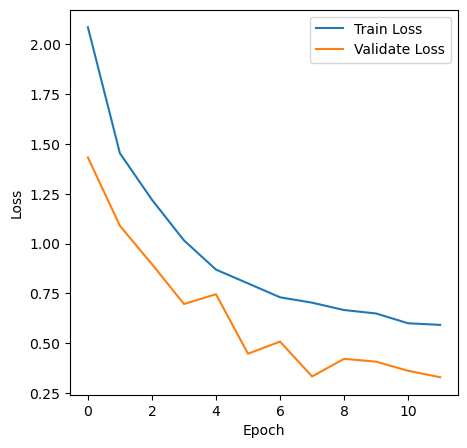

  6%|████▌                                                                        | 12/200 [48:16<12:27:05, 238.44s/it]

Epoch:12
Time:0:52:03.899913
Loss:0.4221314979961124
Total:10000  Correct:8739  CleanAccuracy:0.8739


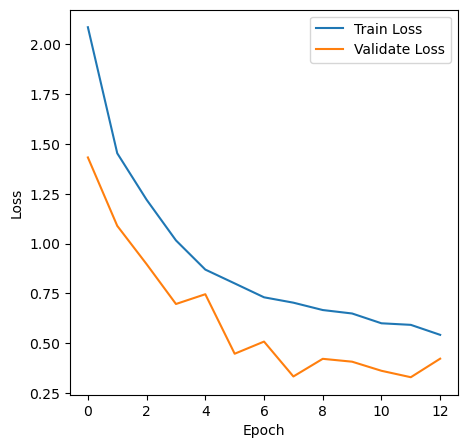

  6%|█████                                                                        | 13/200 [52:12<12:20:49, 237.70s/it]

Epoch:13
Time:0:56:01.189831
Loss:0.2770088080840465
Total:10000  Correct:9131  CleanAccuracy:0.9131


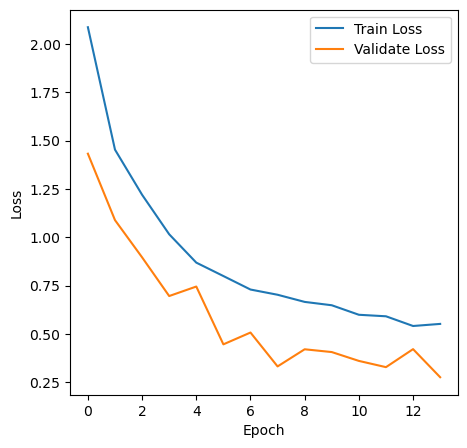

  7%|█████▍                                                                       | 14/200 [56:10<12:16:30, 237.58s/it]

Epoch:14
Time:0:59:58.416858
Loss:0.23519580324474995
Total:10000  Correct:9250  CleanAccuracy:0.9250


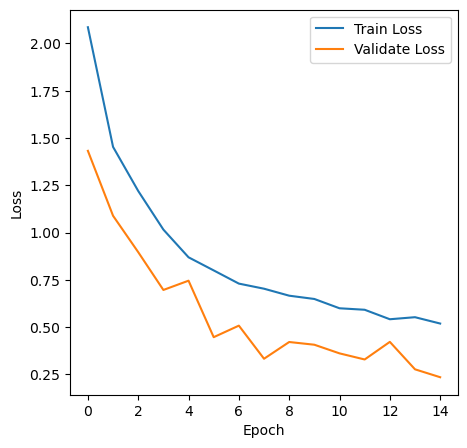

  8%|█████▋                                                                     | 15/200 [1:00:07<12:12:11, 237.47s/it]

Epoch:15
Time:1:03:54.840207
Loss:0.283606981555113
Total:10000  Correct:9042  CleanAccuracy:0.9042


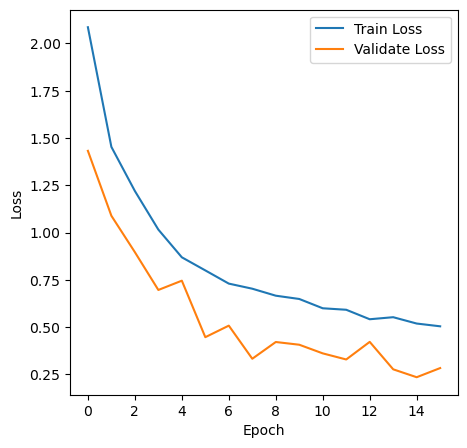

  8%|██████                                                                     | 16/200 [1:04:03<12:07:06, 237.10s/it]

Epoch:16
Time:1:08:20.999363
Loss:0.31283991732679234
Total:10000  Correct:8974  CleanAccuracy:0.8974


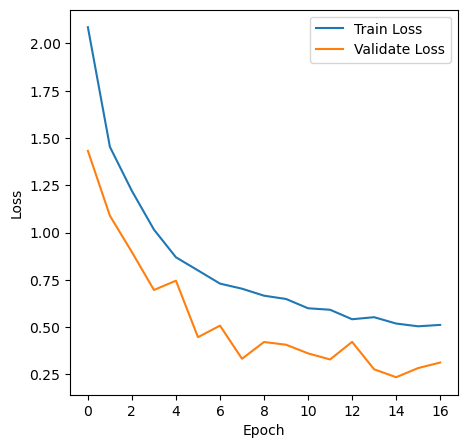

  8%|██████▍                                                                    | 17/200 [1:08:31<12:31:03, 246.25s/it]

Epoch:17
Time:1:12:29.735223
Loss:0.2574673328346338
Total:10000  Correct:9180  CleanAccuracy:0.9180


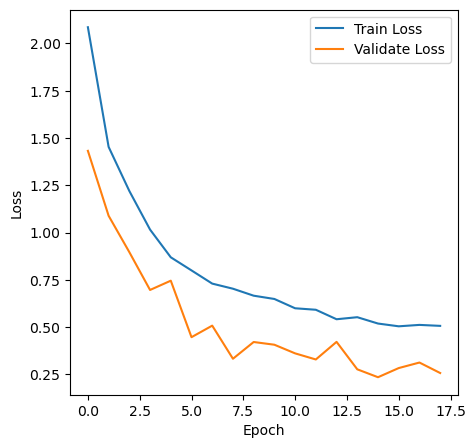

  9%|██████▊                                                                    | 18/200 [1:12:40<12:29:45, 247.18s/it]

Epoch:18
Time:1:17:42.857725
Loss:0.27548607024914634
Total:10000  Correct:9172  CleanAccuracy:0.9172


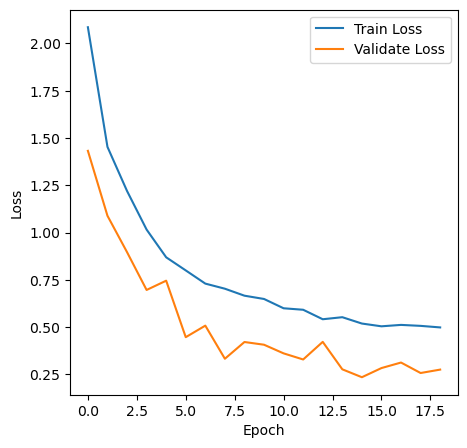

 10%|███████▏                                                                   | 19/200 [1:17:54<13:25:53, 267.14s/it]

Epoch:19
Time:1:23:16.161000
Loss:0.2345481862406285
Total:10000  Correct:9269  CleanAccuracy:0.9269


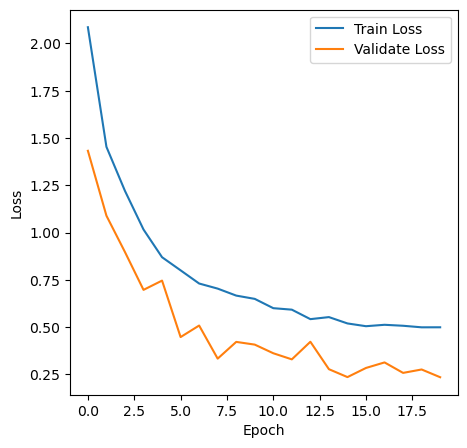

 10%|███████▌                                                                   | 20/200 [1:23:26<14:20:21, 286.79s/it]

Epoch:20
Time:1:28:54.491379
Loss:0.25268013944355444
Total:10000  Correct:9199  CleanAccuracy:0.9199


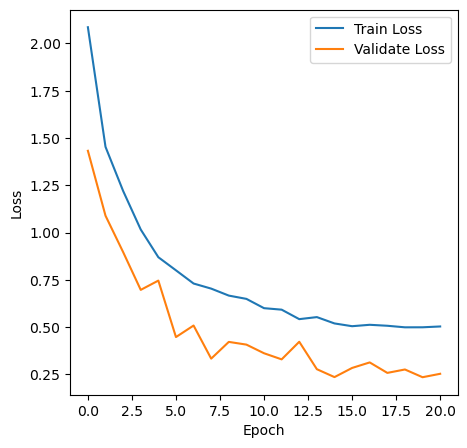

 10%|███████▉                                                                   | 21/200 [1:29:05<15:02:40, 302.57s/it]

Epoch:21
Time:1:34:20.045073
Loss:0.3833901468462076
Total:10000  Correct:8734  CleanAccuracy:0.8734


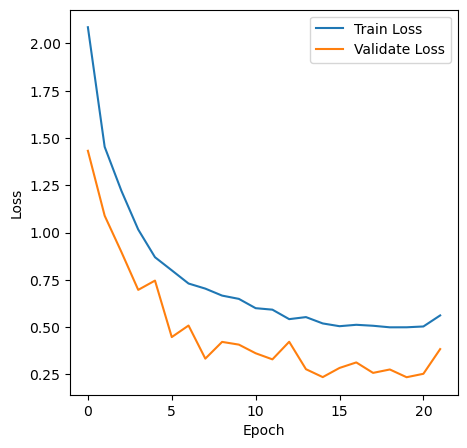

 11%|████████▎                                                                  | 22/200 [1:34:31<15:17:43, 309.35s/it]

Epoch:22
Time:1:40:00.044033
Loss:0.3367636374676951
Total:10000  Correct:8933  CleanAccuracy:0.8933


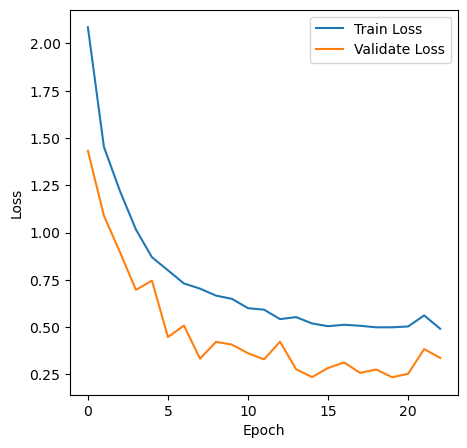

 12%|████████▋                                                                  | 23/200 [1:40:10<15:39:23, 318.44s/it]

Epoch:23
Time:1:45:40.104477
Loss:0.3478180794908216
Total:10000  Correct:8911  CleanAccuracy:0.8911


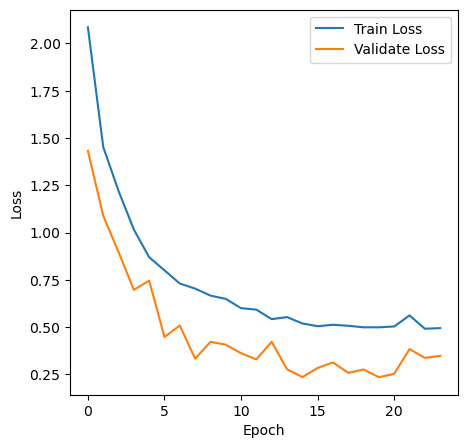

 12%|█████████                                                                  | 24/200 [1:45:50<15:53:04, 324.91s/it]

Epoch:24
Time:1:51:16.930676
Loss:0.28339520027152837
Total:10000  Correct:9138  CleanAccuracy:0.9138


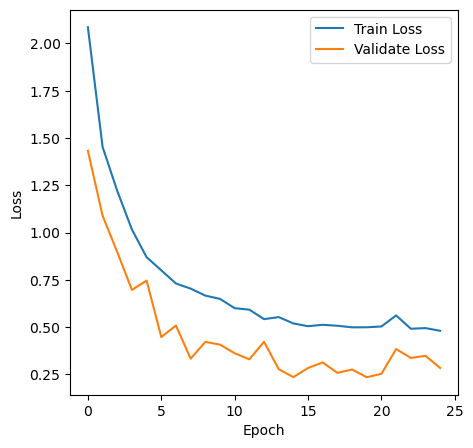

 12%|█████████▍                                                                 | 25/200 [1:51:27<15:58:08, 328.51s/it]

Epoch:25
Time:1:56:36.053517
Loss:0.25806568479671266
Total:10000  Correct:9175  CleanAccuracy:0.9175


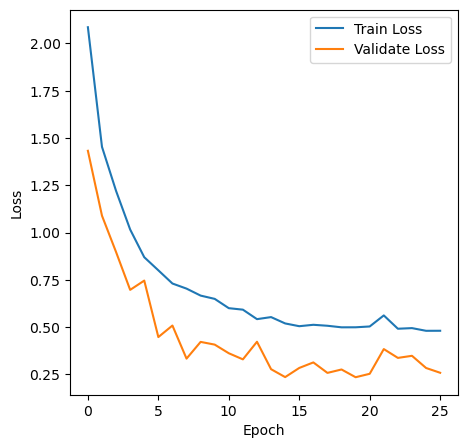

 13%|█████████▊                                                                 | 26/200 [1:56:47<15:44:43, 325.77s/it]

Epoch:26
Time:2:01:30.551174
Loss:0.3849843276765781
Total:10000  Correct:8720  CleanAccuracy:0.8720


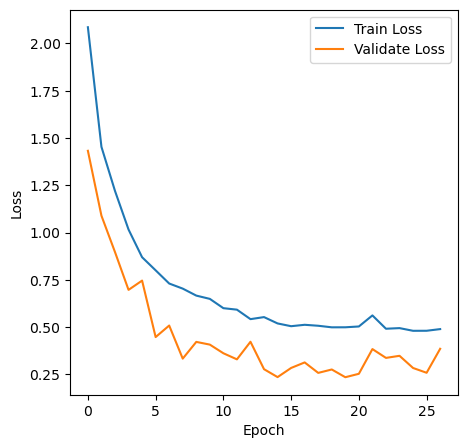

 14%|██████████▏                                                                | 27/200 [2:01:38<15:09:38, 315.48s/it]

Epoch:27
Time:2:06:04.550867
Loss:0.2589711260598022
Total:10000  Correct:9140  CleanAccuracy:0.9140


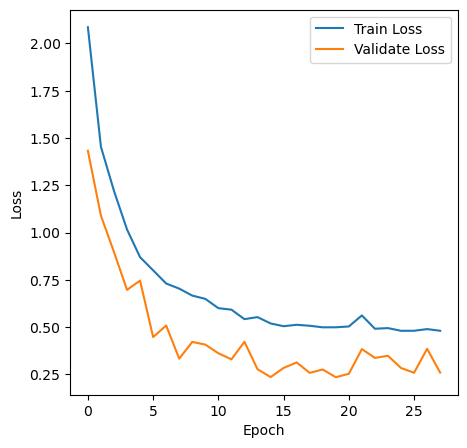

 14%|██████████▌                                                                | 28/200 [2:06:13<14:29:27, 303.30s/it]

Epoch:28
Time:2:10:36.939908
Loss:0.3673425528009574
Total:10000  Correct:8739  CleanAccuracy:0.8739


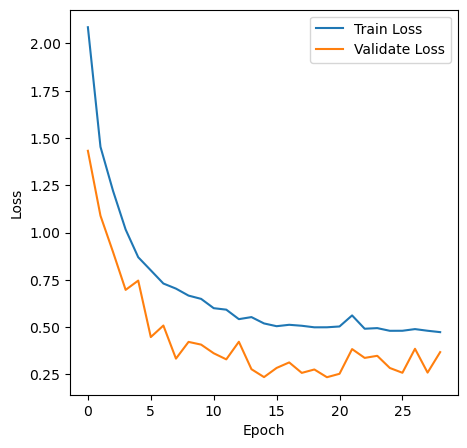

 14%|██████████▉                                                                | 29/200 [2:10:45<13:57:52, 293.99s/it]

Epoch:29
Time:2:15:26.152676
Loss:0.3103757794625081
Total:10000  Correct:8963  CleanAccuracy:0.8963


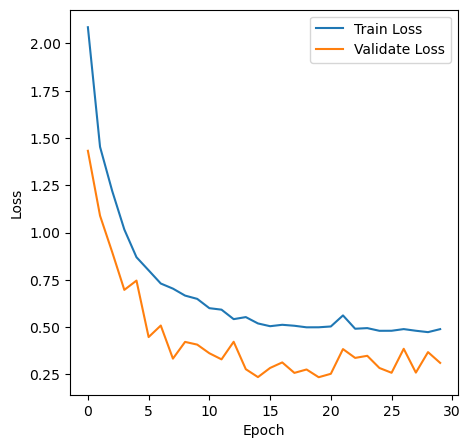

 15%|███████████▎                                                               | 30/200 [2:15:35<13:49:39, 292.82s/it]

Epoch:30
Time:2:20:37.293519
Loss:0.30458629253906566
Total:10000  Correct:9033  CleanAccuracy:0.9033


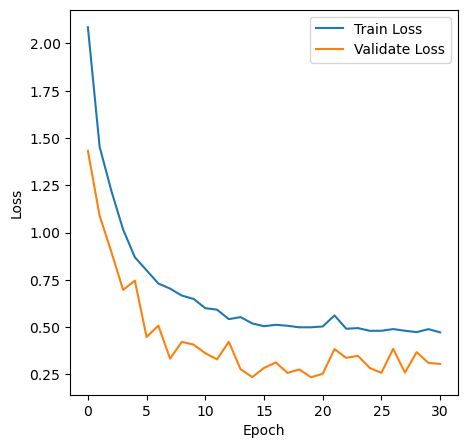

 16%|███████████▋                                                               | 31/200 [2:20:47<14:01:11, 298.65s/it]

Epoch:31
Time:2:25:16.256432
Loss:0.26276661323520323
Total:10000  Correct:9191  CleanAccuracy:0.9191


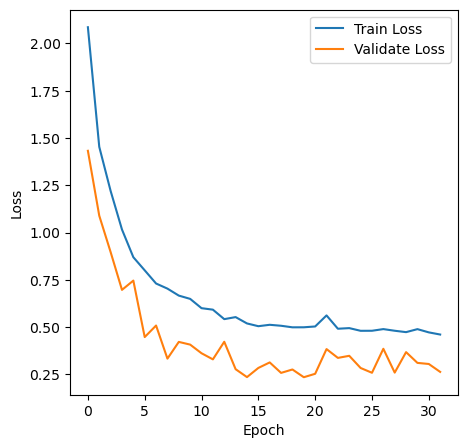

 16%|████████████                                                               | 32/200 [2:25:24<13:38:01, 292.15s/it]

Epoch:32
Time:2:30:12.098808
Loss:0.4552787376311831
Total:10000  Correct:8469  CleanAccuracy:0.8469


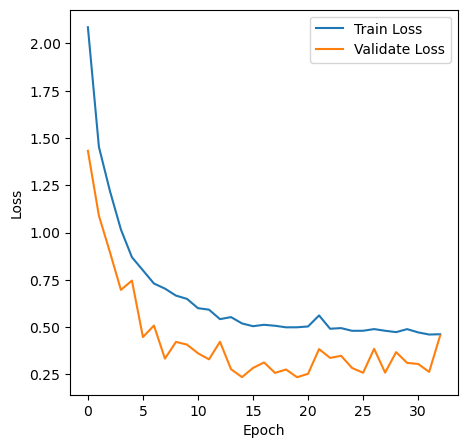

 16%|████████████▍                                                              | 33/200 [2:30:21<13:37:03, 293.56s/it]

Epoch:33
Time:2:34:37.944163
Loss:0.2366976941676852
Total:10000  Correct:9278  CleanAccuracy:0.9278


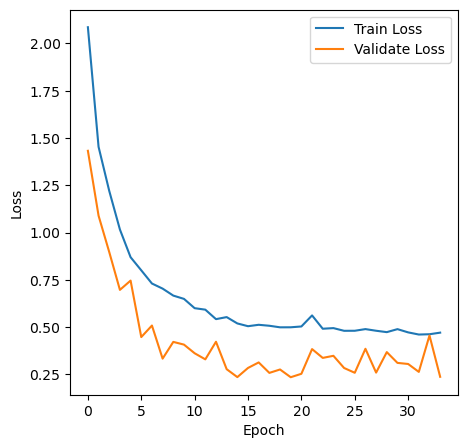

 17%|████████████▊                                                              | 34/200 [2:34:46<13:08:20, 284.94s/it]

Epoch:34
Time:2:38:57.905513
Loss:0.3702731013012389
Total:10000  Correct:8759  CleanAccuracy:0.8759


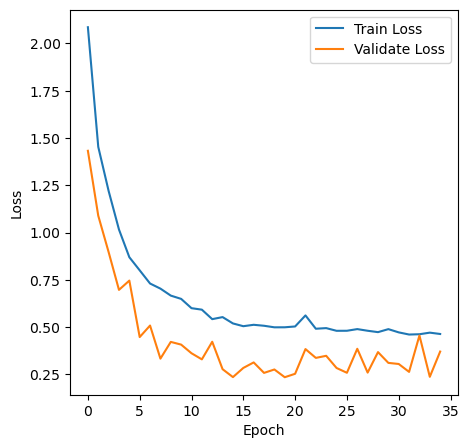

 18%|█████████████▏                                                             | 35/200 [2:39:06<12:42:38, 277.33s/it]

Epoch:35
Time:2:43:34.066322
Loss:0.24537139399625812
Total:10000  Correct:9242  CleanAccuracy:0.9242


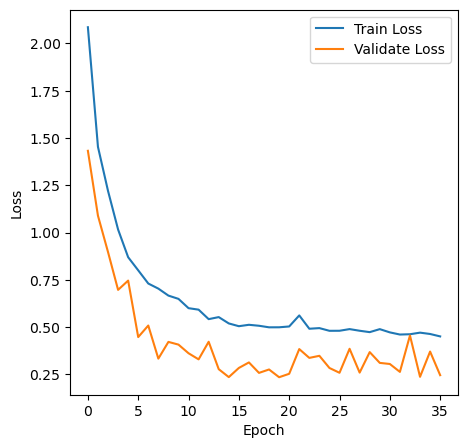

 18%|█████████████▌                                                             | 36/200 [2:43:46<12:40:09, 278.11s/it]

Epoch:36
Time:2:49:17.108747
Loss:0.3251751364170077
Total:10000  Correct:8959  CleanAccuracy:0.8959


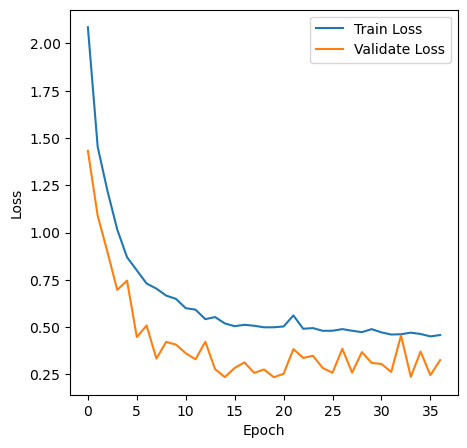

 18%|█████████████▉                                                             | 37/200 [2:49:28<13:27:44, 297.33s/it]

Epoch:37
Time:2:53:49.401422
Loss:0.2329097555135005
Total:10000  Correct:9357  CleanAccuracy:0.9357


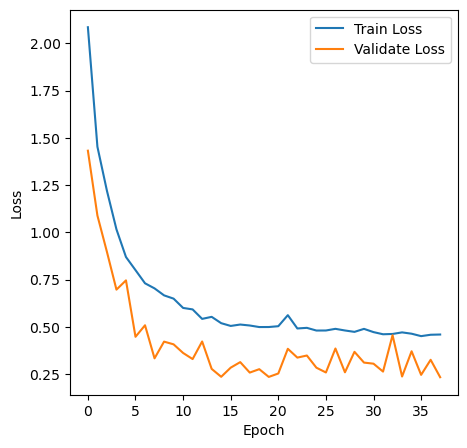

 19%|██████████████▎                                                            | 38/200 [2:53:58<13:00:36, 289.12s/it]

Epoch:38
Time:2:59:14.098706
Loss:0.271493839439207
Total:10000  Correct:9161  CleanAccuracy:0.9161


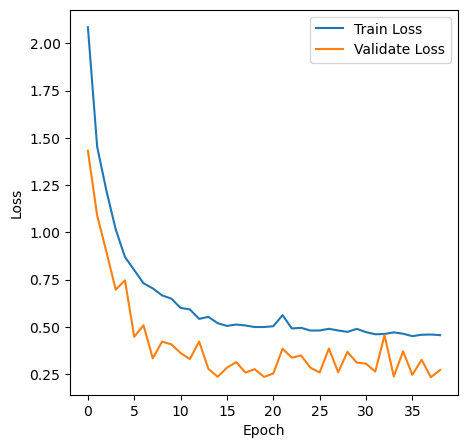

 20%|██████████████▋                                                            | 39/200 [2:59:25<13:26:05, 300.40s/it]

Epoch:39
Time:3:04:55.011589
Loss:0.24115253327944028
Total:10000  Correct:9220  CleanAccuracy:0.9220


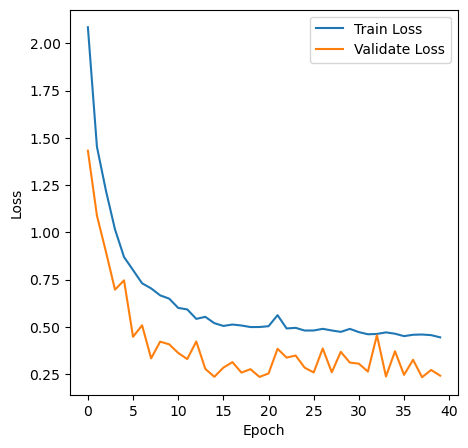

 20%|███████████████                                                            | 40/200 [3:05:06<13:53:37, 312.61s/it]

Epoch:40
Time:3:10:31.295093
Loss:0.33562128806409364
Total:10000  Correct:8887  CleanAccuracy:0.8887


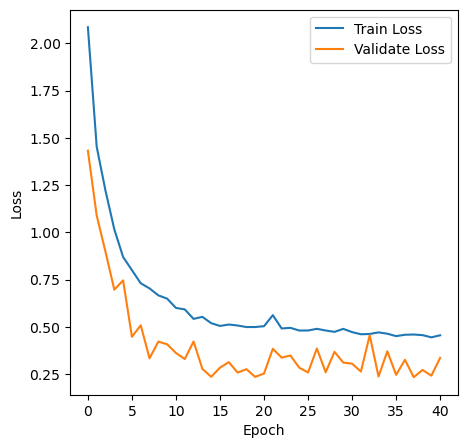

 20%|███████████████▎                                                           | 41/200 [3:10:41<14:06:52, 319.58s/it]

Epoch:41
Time:3:15:23.497929
Loss:0.2545815498089067
Total:10000  Correct:9171  CleanAccuracy:0.9171


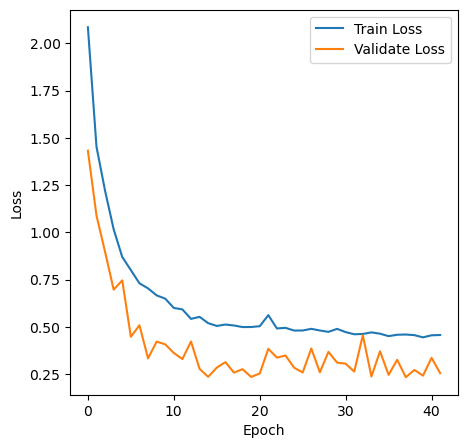

 21%|███████████████▊                                                           | 42/200 [3:15:32<13:38:41, 310.90s/it]

Epoch:42
Time:3:19:55.386963
Loss:0.22402832473214632
Total:10000  Correct:9298  CleanAccuracy:0.9298


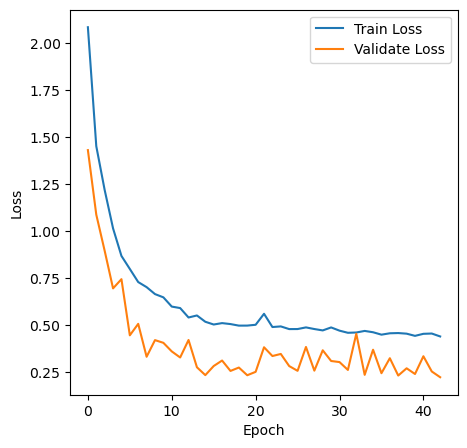

 22%|████████████████▏                                                          | 43/200 [3:20:04<13:02:32, 299.06s/it]

Epoch:43
Time:3:24:12.960217
Loss:0.41166705875017773
Total:10000  Correct:8609  CleanAccuracy:0.8609


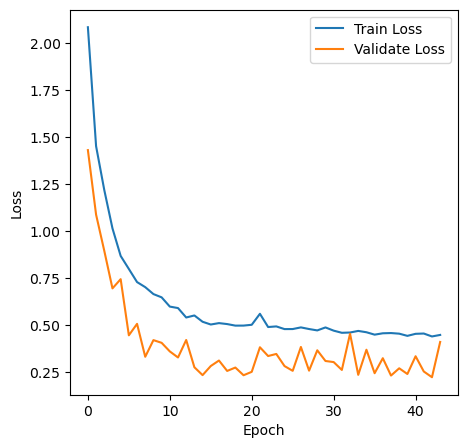

 22%|████████████████▌                                                          | 44/200 [3:24:21<12:25:14, 286.63s/it]

Epoch:44
Time:3:28:45.819870
Loss:0.3120214008866027
Total:10000  Correct:8985  CleanAccuracy:0.8985


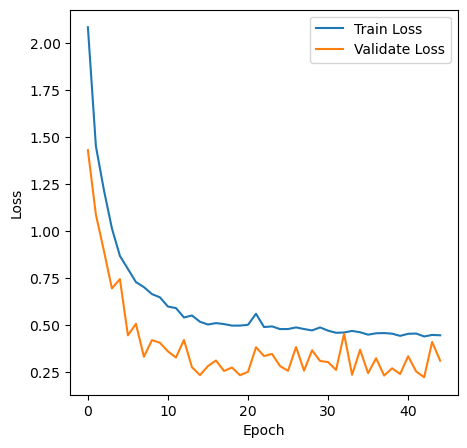

 22%|████████████████▉                                                          | 45/200 [3:28:55<12:10:33, 282.80s/it]

Epoch:45
Time:3:33:19.094552
Loss:0.30706564732157765
Total:10000  Correct:8983  CleanAccuracy:0.8983


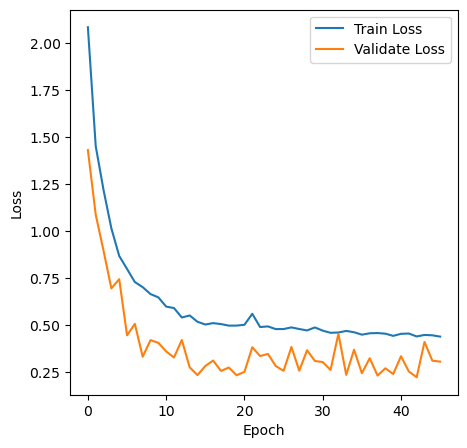

 23%|█████████████████▎                                                         | 46/200 [3:33:28<11:58:23, 279.89s/it]

Epoch:46
Time:3:38:26.496173
Loss:0.22836268317109099
Total:10000  Correct:9283  CleanAccuracy:0.9283


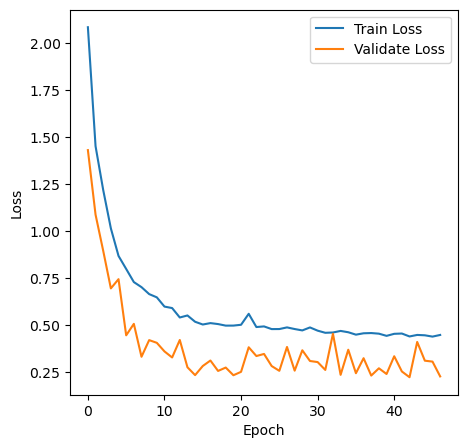

 24%|█████████████████▋                                                         | 47/200 [3:38:37<12:15:58, 288.62s/it]

Epoch:47
Time:3:43:30.817358
Loss:0.26893722434965567
Total:10000  Correct:9156  CleanAccuracy:0.9156


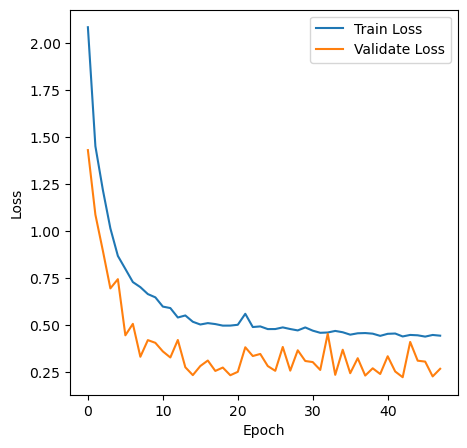

 24%|██████████████████                                                         | 48/200 [3:43:40<12:22:19, 293.02s/it]

Epoch:48
Time:3:48:09.173420
Loss:0.3162662604758248
Total:10000  Correct:8955  CleanAccuracy:0.8955


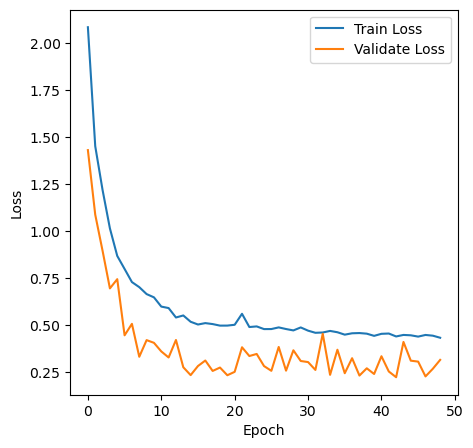

 24%|██████████████████▍                                                        | 49/200 [3:48:17<12:05:24, 288.24s/it]

Epoch:49
Time:3:52:25.902355
Loss:0.33218013200040064
Total:10000  Correct:8907  CleanAccuracy:0.8907


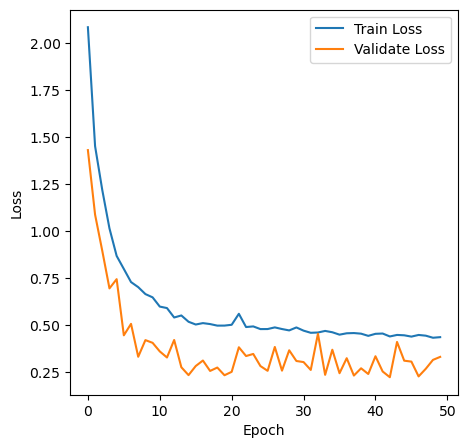

 25%|██████████████████▊                                                        | 50/200 [3:52:34<11:36:28, 278.59s/it]

Epoch:50
Time:3:56:55.871790
Loss:0.30139864583056386
Total:10000  Correct:9014  CleanAccuracy:0.9014


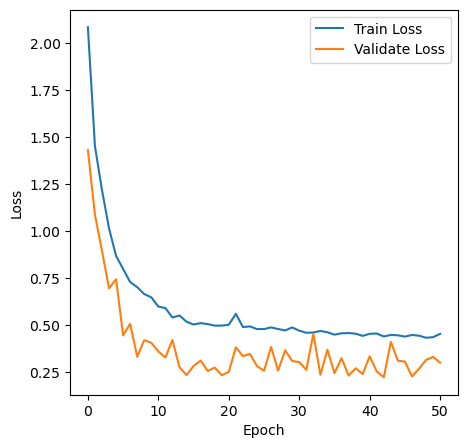

 26%|███████████████████▏                                                       | 51/200 [3:57:04<11:25:58, 276.23s/it]

Epoch:51
Time:4:01:13.919599
Loss:0.25788433401705546
Total:10000  Correct:9170  CleanAccuracy:0.9170


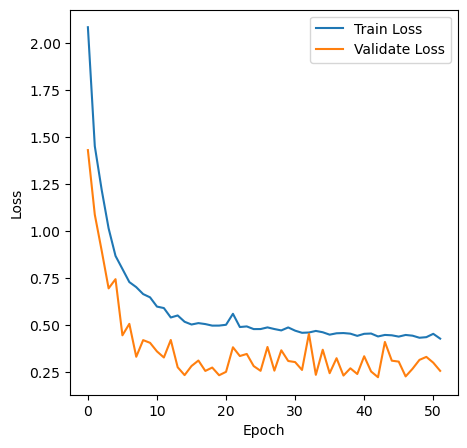

 26%|███████████████████▌                                                       | 52/200 [4:01:22<11:07:57, 270.79s/it]

Epoch:52
Time:4:05:54.032121
Loss:0.3154884043831033
Total:10000  Correct:9062  CleanAccuracy:0.9062


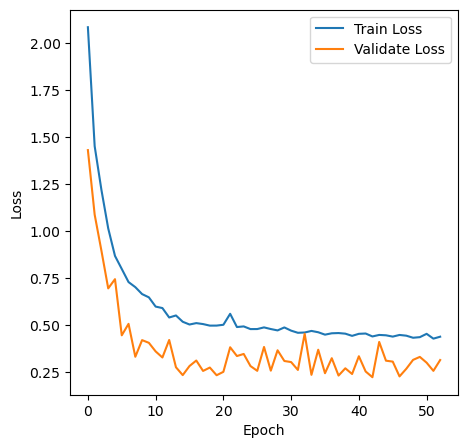

 26%|███████████████████▉                                                       | 53/200 [4:06:04<11:11:26, 274.06s/it]

Epoch:53
Time:4:11:10.375564
Loss:0.3084385598215242
Total:10000  Correct:9054  CleanAccuracy:0.9054


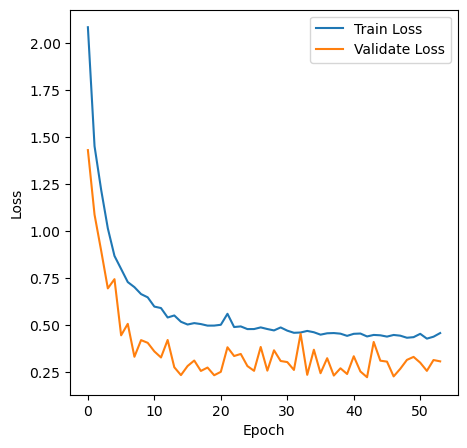

 27%|████████████████████▎                                                      | 54/200 [4:11:20<11:37:38, 286.70s/it]

Epoch:54
Time:4:15:38.635100
Loss:0.3644304005934979
Total:10000  Correct:8801  CleanAccuracy:0.8801


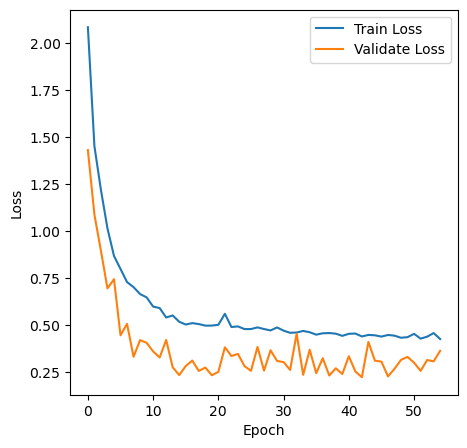

 28%|████████████████████▋                                                      | 55/200 [4:15:47<11:18:18, 280.68s/it]

Epoch:55
Time:4:19:55.198039
Loss:0.35390100947703224
Total:10000  Correct:8800  CleanAccuracy:0.8800


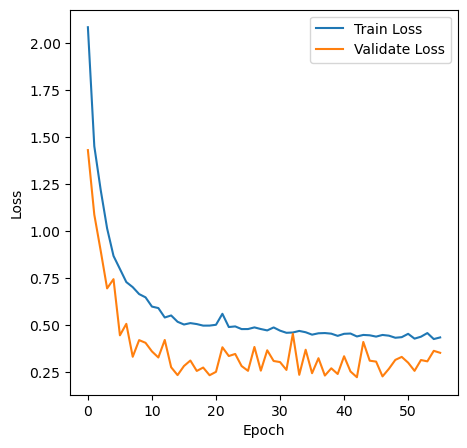

 28%|█████████████████████                                                      | 56/200 [4:20:04<10:56:25, 273.51s/it]

Epoch:56
Time:4:24:15.339191
Loss:0.19755900575044438
Total:10000  Correct:9369  CleanAccuracy:0.9369


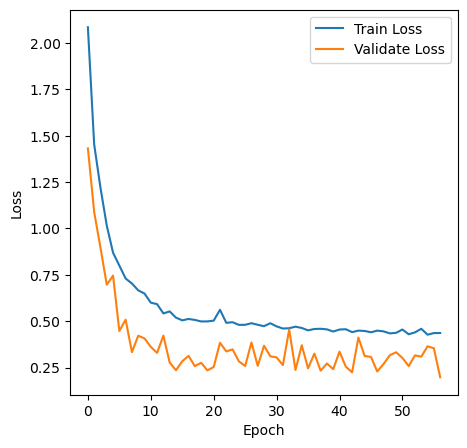

 28%|█████████████████████▎                                                     | 57/200 [4:24:24<10:42:18, 269.50s/it]

Epoch:57
Time:4:28:54.950450
Loss:0.24476764092263512
Total:10000  Correct:9222  CleanAccuracy:0.9222


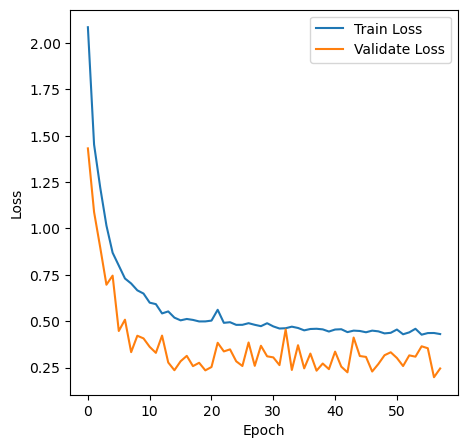

 29%|█████████████████████▊                                                     | 58/200 [4:29:03<10:44:55, 272.50s/it]

Epoch:58
Time:4:33:12.100637
Loss:0.24799720896556735
Total:10000  Correct:9235  CleanAccuracy:0.9235


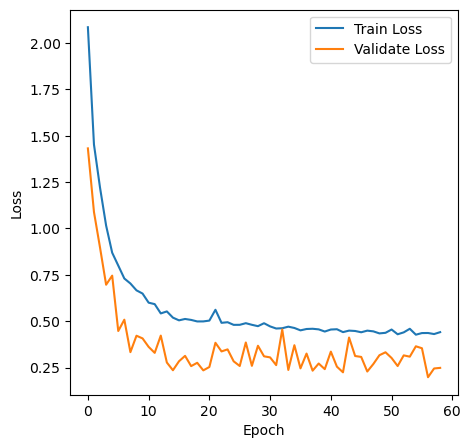

 30%|██████████████████████▏                                                    | 59/200 [4:33:21<10:29:37, 267.93s/it]

Epoch:59
Time:4:38:02.212892
Loss:0.21717990894977468
Total:10000  Correct:9336  CleanAccuracy:0.9336


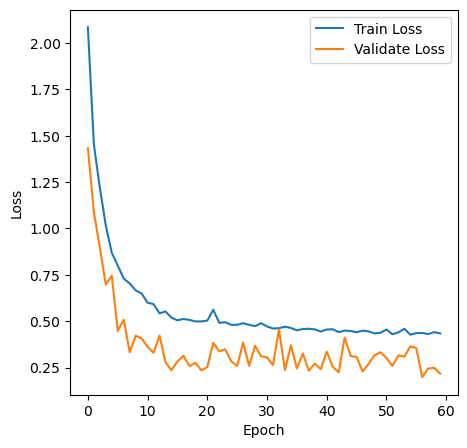

 30%|██████████████████████▌                                                    | 60/200 [4:38:11<10:41:07, 274.77s/it]

Epoch:60
Time:4:42:29.187855
Loss:0.09301000606222525
Total:10000  Correct:9716  CleanAccuracy:0.9716


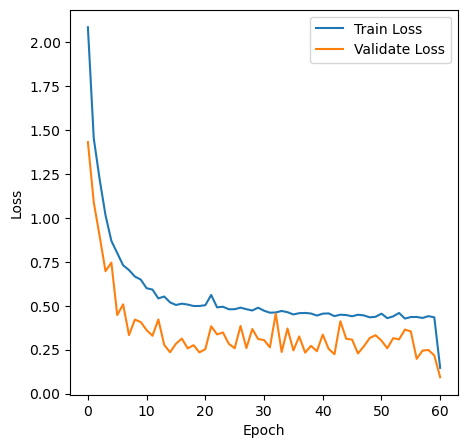

 30%|██████████████████████▉                                                    | 61/200 [4:42:38<10:30:39, 272.22s/it]

Epoch:61
Time:4:47:27.234353
Loss:0.07807557520228989
Total:10000  Correct:9751  CleanAccuracy:0.9751


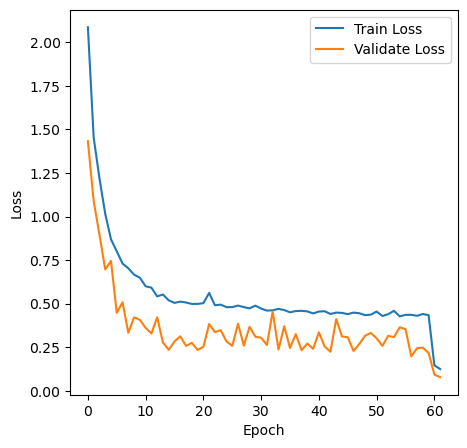

 31%|███████████████████████▎                                                   | 62/200 [4:47:37<10:45:04, 280.47s/it]

Epoch:62
Time:4:51:48.763749
Loss:0.08030920248358145
Total:10000  Correct:9742  CleanAccuracy:0.9742


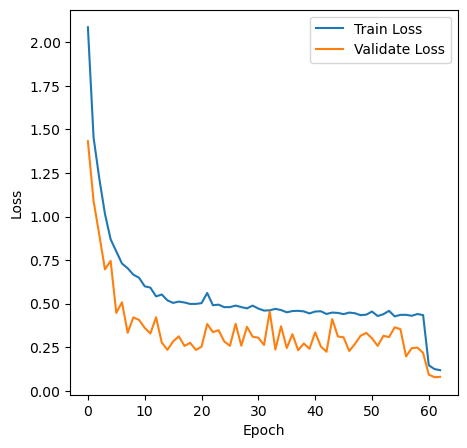

 32%|███████████████████████▋                                                   | 63/200 [4:51:57<10:26:17, 274.29s/it]

Epoch:63
Time:4:56:08.186199
Loss:0.07783188080316938
Total:10000  Correct:9758  CleanAccuracy:0.9758


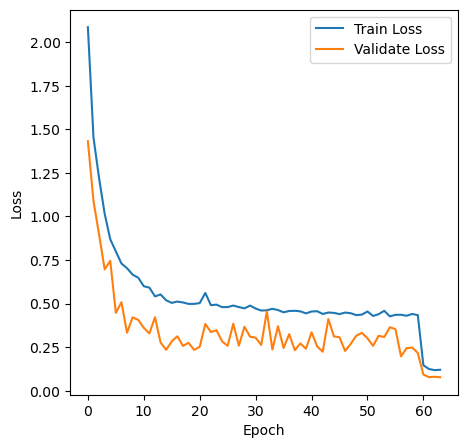

 32%|████████████████████████                                                   | 64/200 [4:56:16<10:11:09, 269.63s/it]

Epoch:64
Time:5:00:57.149434
Loss:0.07669242038525427
Total:10000  Correct:9767  CleanAccuracy:0.9767


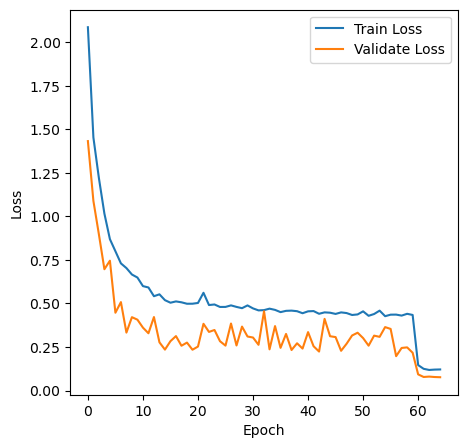

 32%|████████████████████████▍                                                  | 65/200 [5:01:06<10:20:10, 275.63s/it]

Epoch:65
Time:5:05:42.993903
Loss:0.0901230626067105
Total:10000  Correct:9718  CleanAccuracy:0.9718


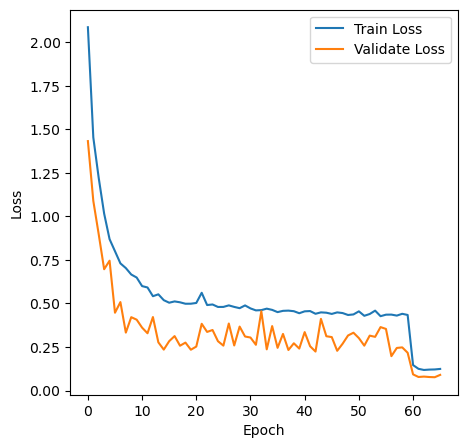

 33%|████████████████████████▊                                                  | 66/200 [5:05:51<10:22:21, 278.67s/it]

Epoch:66
Time:5:09:41.910150
Loss:0.07794957809535542
Total:10000  Correct:9740  CleanAccuracy:0.9740


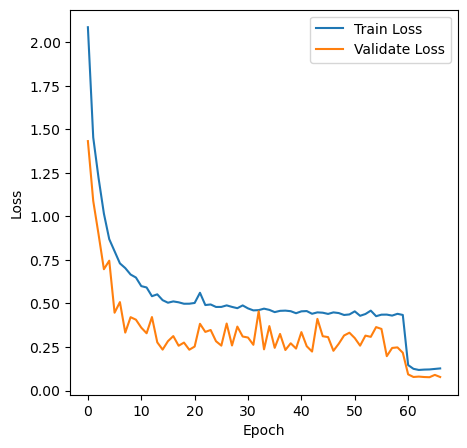

 34%|█████████████████████████▍                                                  | 67/200 [5:09:50<9:51:09, 266.69s/it]

Epoch:67
Time:5:13:40.240389
Loss:0.06936033817711837
Total:10000  Correct:9778  CleanAccuracy:0.9778


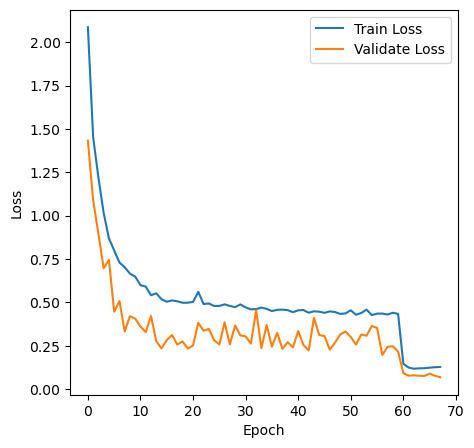

 34%|█████████████████████████▊                                                  | 68/200 [5:13:49<9:28:09, 258.26s/it]

Epoch:68
Time:5:17:45.698687
Loss:0.07199772845856256
Total:10000  Correct:9767  CleanAccuracy:0.9767


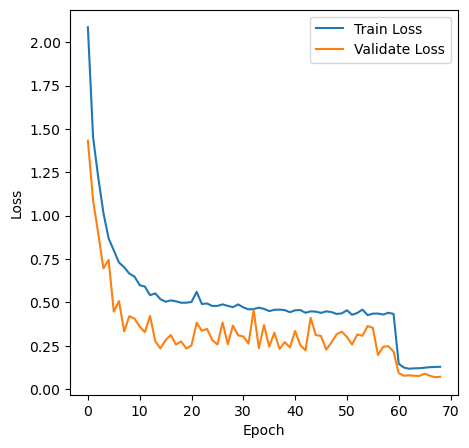

 34%|██████████████████████████▏                                                 | 69/200 [5:17:54<9:15:28, 254.41s/it]

Epoch:69
Time:5:21:46.404486
Loss:0.1491832718953859
Total:10000  Correct:9515  CleanAccuracy:0.9515


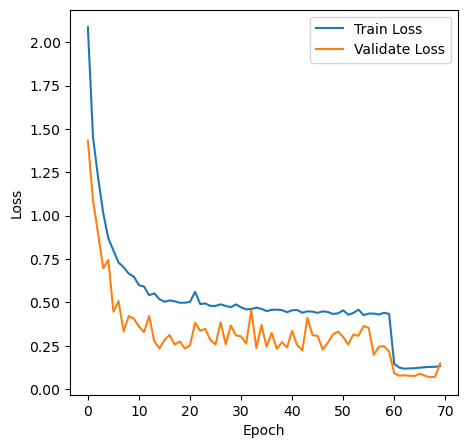

 35%|██████████████████████████▌                                                 | 70/200 [5:21:55<9:02:20, 250.31s/it]

Epoch:70
Time:5:25:46.061243
Loss:0.11375006620427028
Total:10000  Correct:9630  CleanAccuracy:0.9630


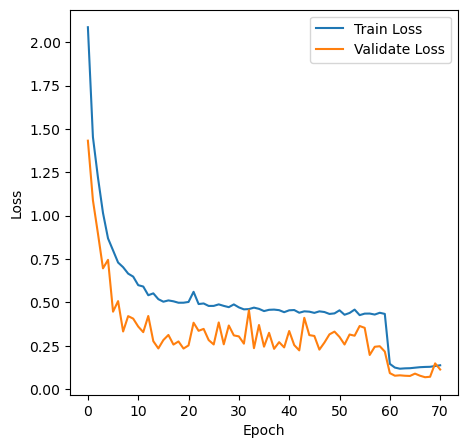

 36%|██████████████████████████▉                                                 | 71/200 [5:25:54<8:51:10, 247.06s/it]

Epoch:71
Time:5:29:45.358552
Loss:0.09625938605218114
Total:10000  Correct:9695  CleanAccuracy:0.9695


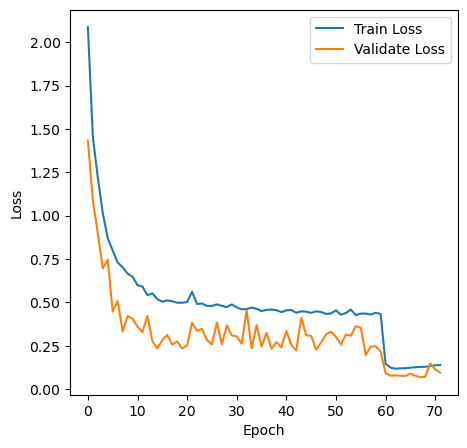

 36%|███████████████████████████▎                                                | 72/200 [5:29:53<8:41:37, 244.51s/it]

Epoch:72
Time:5:33:45.439123
Loss:0.09628430923957307
Total:10000  Correct:9716  CleanAccuracy:0.9716


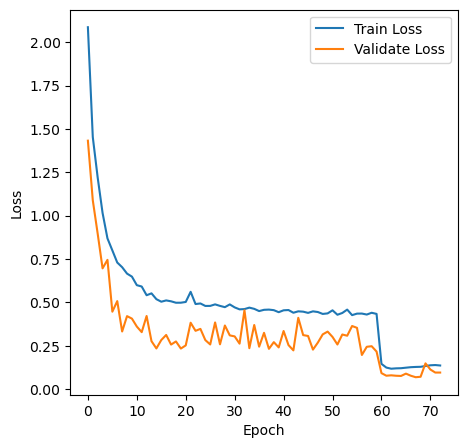

 36%|███████████████████████████▋                                                | 73/200 [5:33:54<8:35:08, 243.37s/it]

Epoch:73
Time:5:37:44.997203
Loss:0.06780524021230293
Total:10000  Correct:9794  CleanAccuracy:0.9794


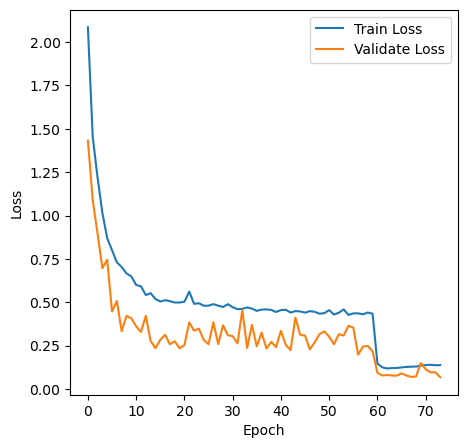

 37%|████████████████████████████                                                | 74/200 [5:37:53<8:28:28, 242.13s/it]

Epoch:74
Time:5:41:42.239451
Loss:0.08865154214306012
Total:10000  Correct:9716  CleanAccuracy:0.9716


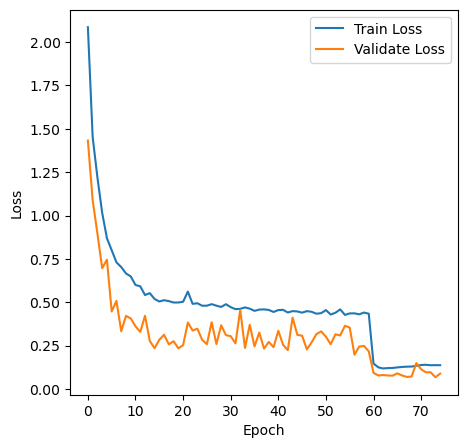

 38%|████████████████████████████▌                                               | 75/200 [5:41:50<8:21:11, 240.57s/it]

Epoch:75
Time:5:45:38.177542
Loss:0.08737748167656076
Total:10000  Correct:9719  CleanAccuracy:0.9719


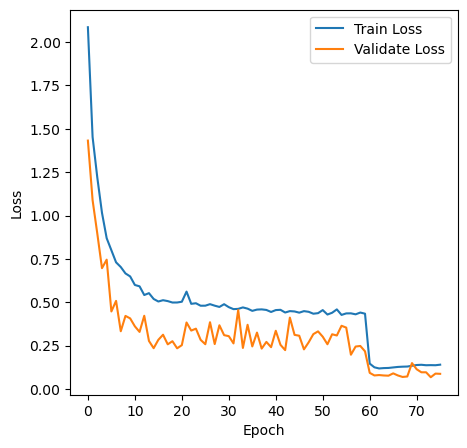

 38%|████████████████████████████▉                                               | 76/200 [5:45:46<8:14:45, 239.40s/it]

Epoch:76
Time:5:49:35.717503
Loss:0.10072548362164618
Total:10000  Correct:9668  CleanAccuracy:0.9668


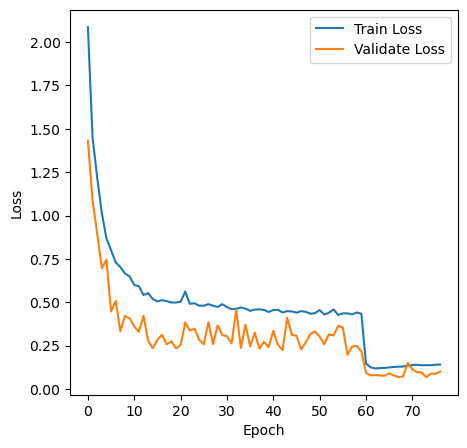

 38%|█████████████████████████████▎                                              | 77/200 [5:49:44<8:09:35, 238.83s/it]

Epoch:77
Time:5:53:30.749431
Loss:0.11016554480675941
Total:10000  Correct:9669  CleanAccuracy:0.9669


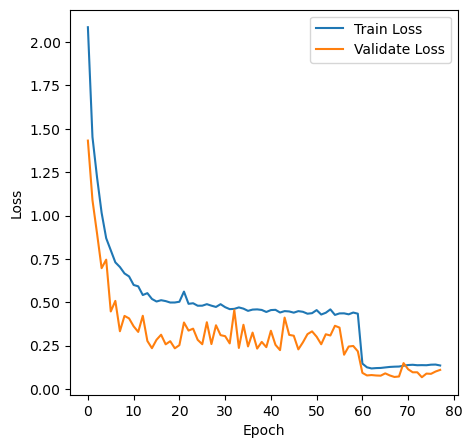

 39%|█████████████████████████████▋                                              | 78/200 [5:53:39<8:03:22, 237.73s/it]

Epoch:78
Time:5:57:26.778053
Loss:0.07163014977734489
Total:10000  Correct:9779  CleanAccuracy:0.9779


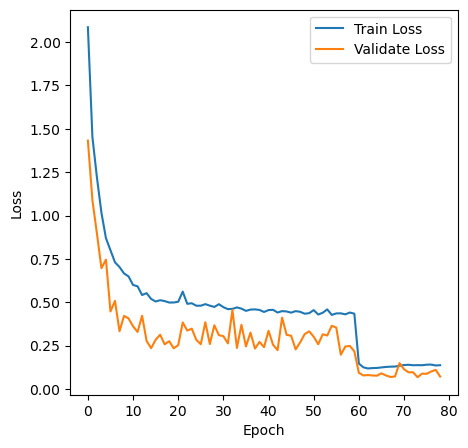

 40%|██████████████████████████████                                              | 79/200 [5:57:35<7:58:19, 237.18s/it]

Epoch:79
Time:6:01:24.401979
Loss:0.07101024146200702
Total:10000  Correct:9804  CleanAccuracy:0.9804


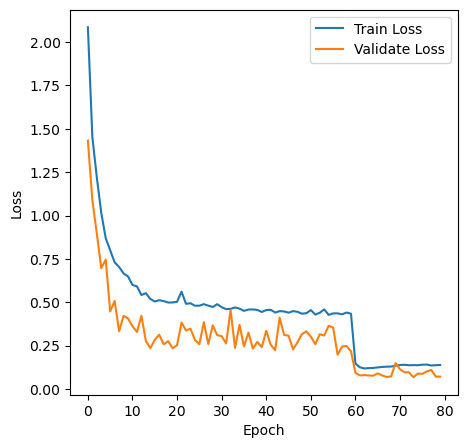

 40%|██████████████████████████████▍                                             | 80/200 [6:01:33<7:54:37, 237.32s/it]

Epoch:80
Time:6:05:21.838410
Loss:0.0837869565887823
Total:10000  Correct:9746  CleanAccuracy:0.9746


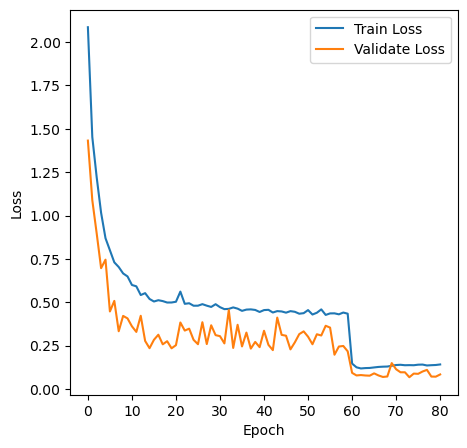

 40%|██████████████████████████████▊                                             | 81/200 [6:05:30<7:50:41, 237.32s/it]

Epoch:81
Time:6:09:18.304039
Loss:0.08083970998056804
Total:10000  Correct:9744  CleanAccuracy:0.9744


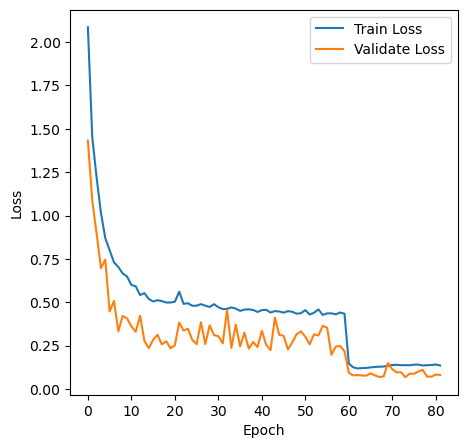

 41%|███████████████████████████████▏                                            | 82/200 [6:09:27<7:46:18, 237.10s/it]

Epoch:82
Time:6:13:14.959125
Loss:0.08823132207698989
Total:10000  Correct:9732  CleanAccuracy:0.9732


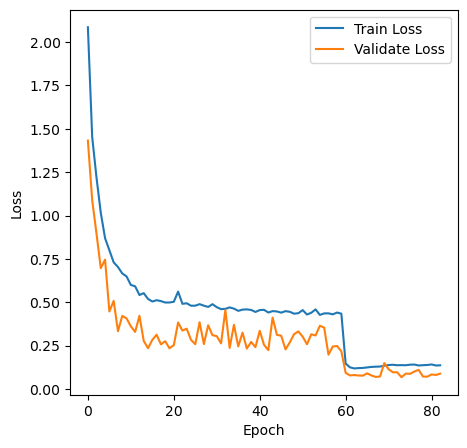

 42%|███████████████████████████████▌                                            | 83/200 [6:13:22<7:41:27, 236.64s/it]

Epoch:83
Time:6:17:09.958187
Loss:0.08113627928158881
Total:10000  Correct:9742  CleanAccuracy:0.9742


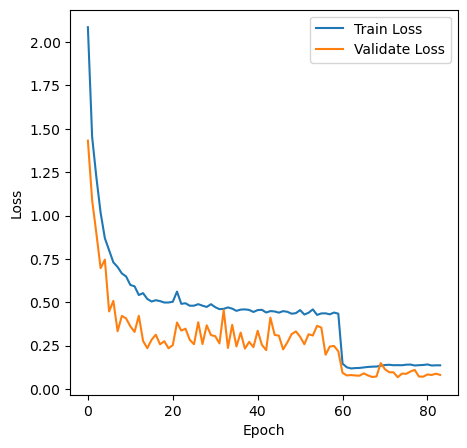

 42%|███████████████████████████████▉                                            | 84/200 [6:17:18<7:36:48, 236.28s/it]

Epoch:84
Time:6:21:05.116226
Loss:0.0666137731648214
Total:10000  Correct:9793  CleanAccuracy:0.9793


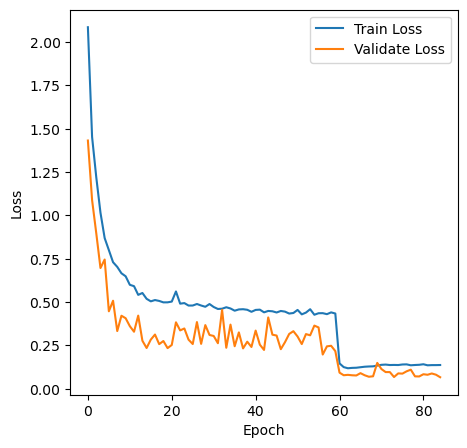

 42%|████████████████████████████████▎                                           | 85/200 [6:21:13<7:32:40, 236.18s/it]

Epoch:85
Time:6:25:01.588854
Loss:0.0740306721371673
Total:10000  Correct:9762  CleanAccuracy:0.9762


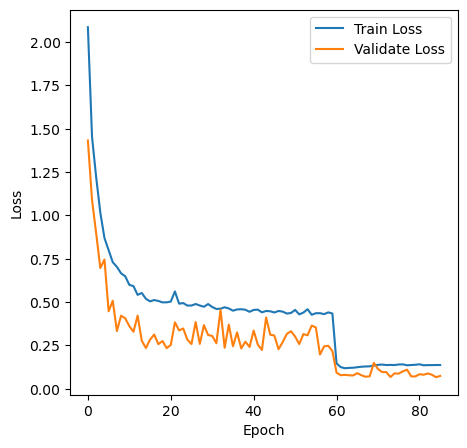

 43%|████████████████████████████████▋                                           | 86/200 [6:25:10<7:28:46, 236.20s/it]

Epoch:86
Time:6:28:56.981672
Loss:0.07907136529535293
Total:10000  Correct:9741  CleanAccuracy:0.9741


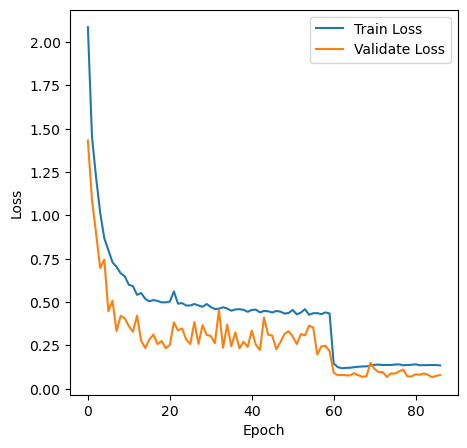

 44%|█████████████████████████████████                                           | 87/200 [6:29:05<7:24:21, 235.94s/it]

Epoch:87
Time:6:32:53.286765
Loss:0.0880301226709282
Total:10000  Correct:9730  CleanAccuracy:0.9730


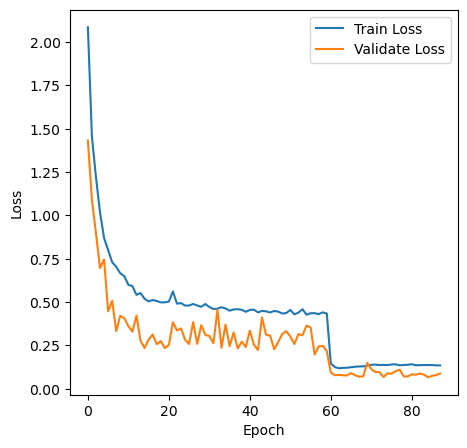

 44%|█████████████████████████████████▍                                          | 88/200 [6:33:01<7:20:39, 236.07s/it]

Epoch:88
Time:6:36:49.351217
Loss:0.1374568251027062
Total:10000  Correct:9586  CleanAccuracy:0.9586


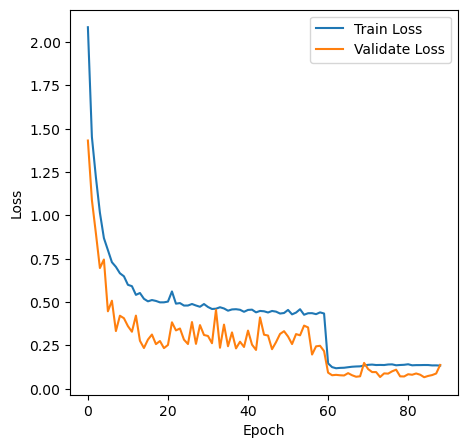

 44%|█████████████████████████████████▊                                          | 89/200 [6:36:57<7:16:40, 236.04s/it]

Epoch:89
Time:6:40:45.114472
Loss:0.07067506741427373
Total:10000  Correct:9777  CleanAccuracy:0.9777


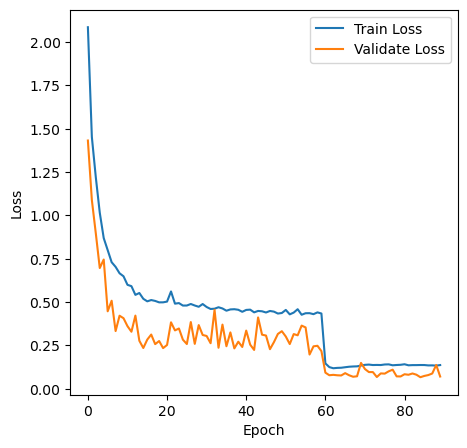

 45%|██████████████████████████████████▏                                         | 90/200 [6:40:53<7:12:36, 235.97s/it]

Epoch:90
Time:6:44:40.986543
Loss:0.06576523908857292
Total:10000  Correct:9800  CleanAccuracy:0.9800


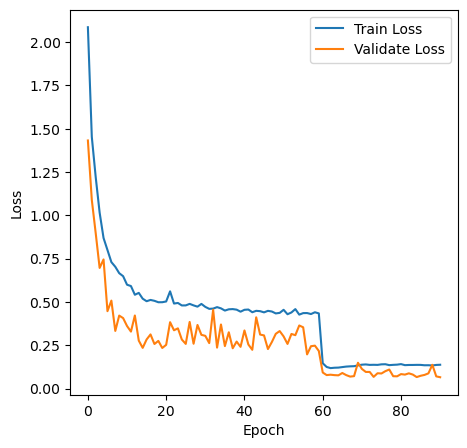

 46%|██████████████████████████████████▌                                         | 91/200 [6:44:49<7:08:38, 235.95s/it]

Epoch:91
Time:6:48:36.437500
Loss:0.08699069514843864
Total:10000  Correct:9715  CleanAccuracy:0.9715


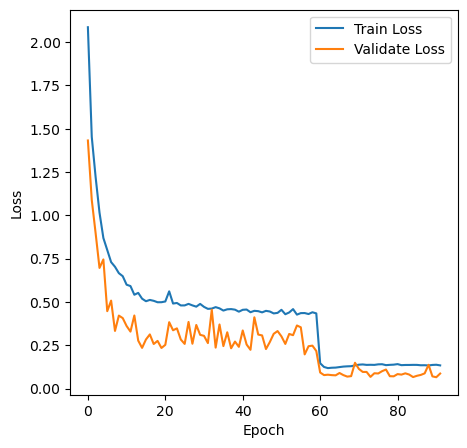

 46%|██████████████████████████████████▉                                         | 92/200 [6:48:44<7:04:13, 235.68s/it]

Epoch:92
Time:6:52:31.919359
Loss:0.08384538627082345
Total:10000  Correct:9730  CleanAccuracy:0.9730


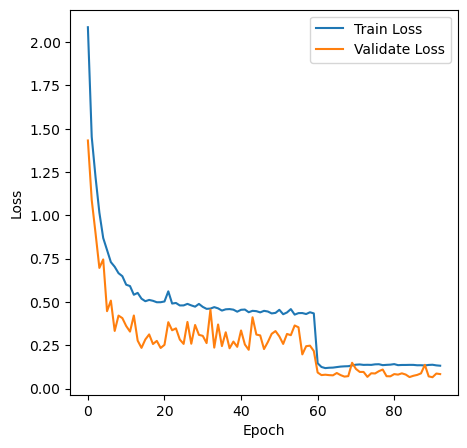

 46%|███████████████████████████████████▎                                        | 93/200 [6:52:40<7:00:21, 235.71s/it]

Epoch:93
Time:6:56:28.140890
Loss:0.07234837216348908
Total:10000  Correct:9779  CleanAccuracy:0.9779


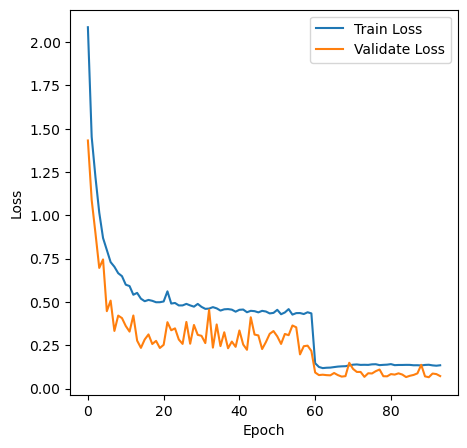

 47%|███████████████████████████████████▋                                        | 94/200 [6:56:36<6:56:42, 235.87s/it]

Epoch:94
Time:7:00:41.058229
Loss:0.0888154550385587
Total:10000  Correct:9713  CleanAccuracy:0.9713


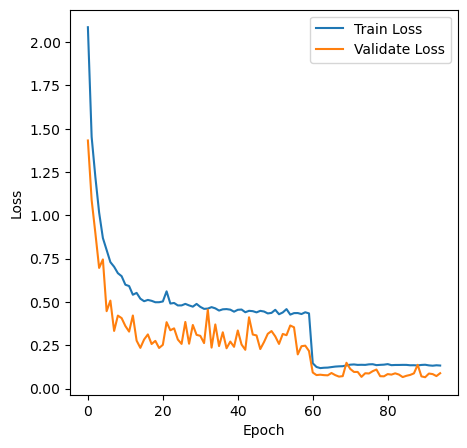

 48%|████████████████████████████████████                                        | 95/200 [7:00:49<7:01:51, 241.06s/it]

Epoch:95
Time:7:04:44.067306
Loss:0.0663430348102646
Total:10000  Correct:9795  CleanAccuracy:0.9795


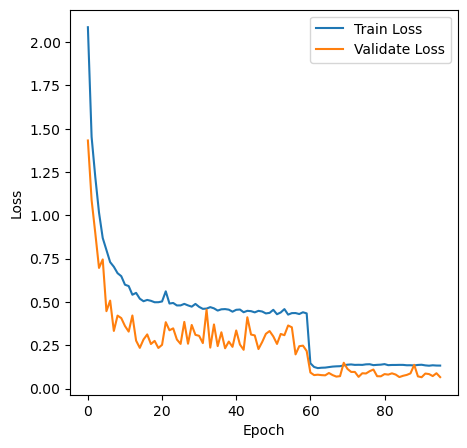

 48%|████████████████████████████████████▍                                       | 96/200 [7:04:52<6:58:35, 241.49s/it]

Epoch:96
Time:7:09:00.655734
Loss:0.09065771535241281
Total:10000  Correct:9691  CleanAccuracy:0.9691


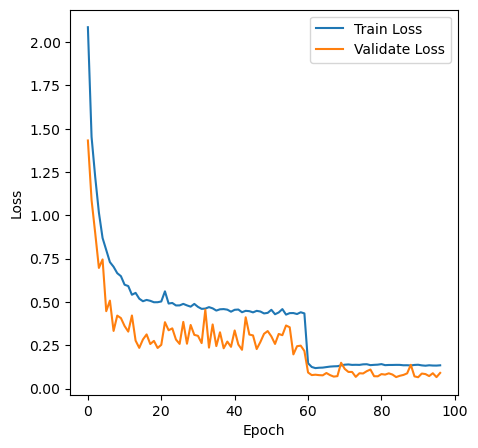

 48%|████████████████████████████████████▊                                       | 97/200 [7:09:09<7:02:48, 246.30s/it]

Epoch:97
Time:7:13:30.106605
Loss:0.06558606932728221
Total:10000  Correct:9806  CleanAccuracy:0.9806


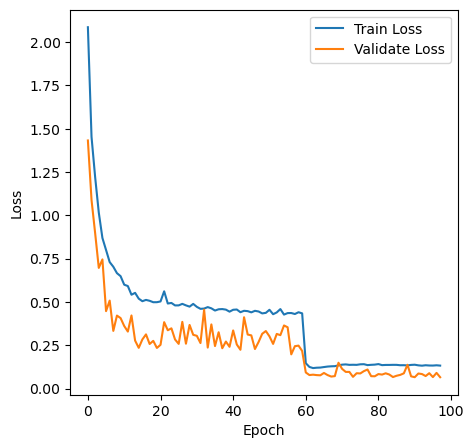

 49%|█████████████████████████████████████▏                                      | 98/200 [7:13:38<7:10:17, 253.11s/it]

Epoch:98
Time:7:17:32.197430
Loss:0.07603568561076106
Total:10000  Correct:9761  CleanAccuracy:0.9761


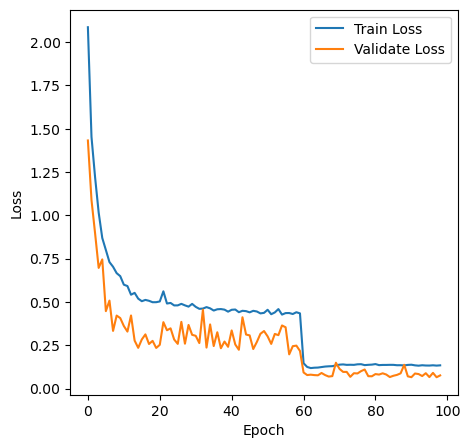

 50%|█████████████████████████████████████▌                                      | 99/200 [7:17:41<7:00:36, 249.87s/it]

Epoch:99
Time:7:21:30.380231
Loss:0.06871196743102369
Total:10000  Correct:9793  CleanAccuracy:0.9793


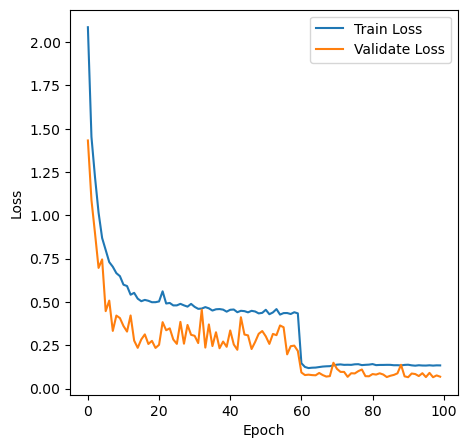

 50%|█████████████████████████████████████▌                                     | 100/200 [7:21:38<6:50:05, 246.05s/it]

Epoch:100
Time:7:25:41.020319
Loss:0.09541907470588522
Total:10000  Correct:9704  CleanAccuracy:0.9704


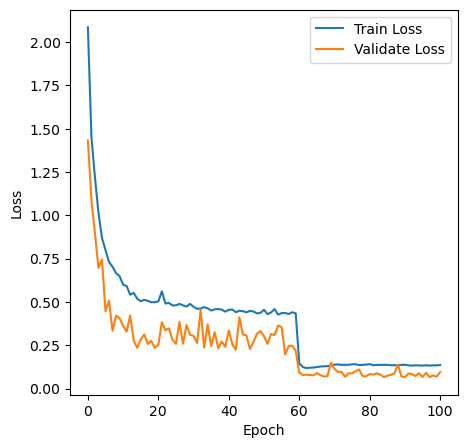

 50%|█████████████████████████████████████▉                                     | 101/200 [7:25:50<6:49:08, 247.97s/it]

Epoch:101
Time:7:29:45.181982
Loss:0.11017549629196727
Total:10000  Correct:9646  CleanAccuracy:0.9646


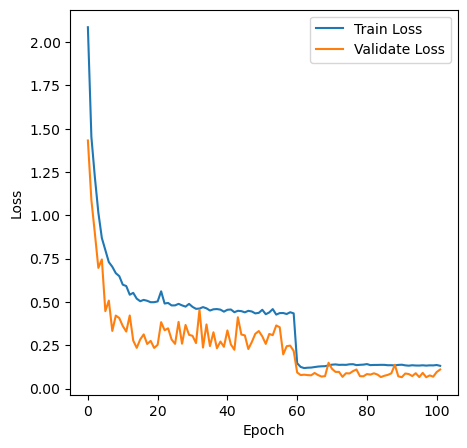

 51%|██████████████████████████████████████▎                                    | 102/200 [7:29:53<6:42:40, 246.53s/it]

Epoch:102
Time:7:33:51.580311
Loss:0.07285912935815442
Total:10000  Correct:9774  CleanAccuracy:0.9774


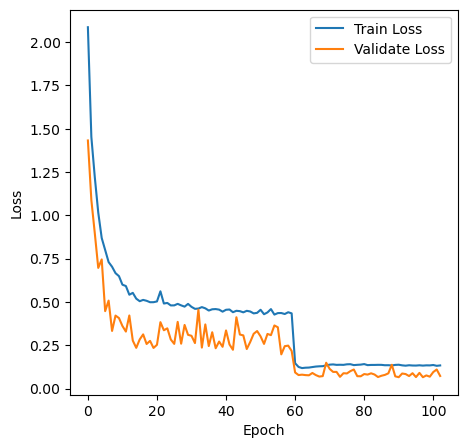

 52%|██████████████████████████████████████▋                                    | 103/200 [7:33:59<6:38:05, 246.24s/it]

Epoch:103
Time:7:38:03.662106
Loss:0.08873638895246537
Total:10000  Correct:9716  CleanAccuracy:0.9716


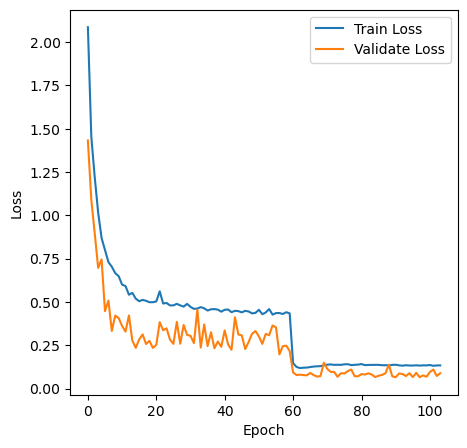

 52%|███████████████████████████████████████                                    | 104/200 [7:38:12<6:37:24, 248.38s/it]

Epoch:104
Time:7:42:19.146645
Loss:0.10142125286453496
Total:10000  Correct:9676  CleanAccuracy:0.9676


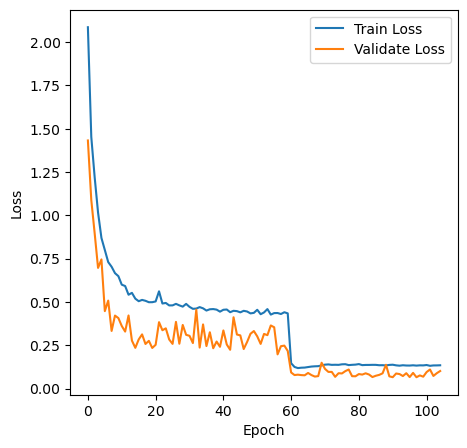

 52%|███████████████████████████████████████▍                                   | 105/200 [7:42:27<6:36:23, 250.36s/it]

Epoch:105
Time:7:46:31.696782
Loss:0.07719619324696385
Total:10000  Correct:9772  CleanAccuracy:0.9772


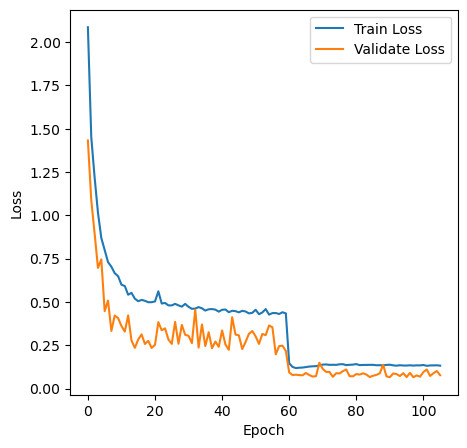

 53%|███████████████████████████████████████▊                                   | 106/200 [7:46:41<6:33:51, 251.40s/it]

Epoch:106
Time:7:51:26.412234
Loss:0.09506232749459485
Total:10000  Correct:9712  CleanAccuracy:0.9712


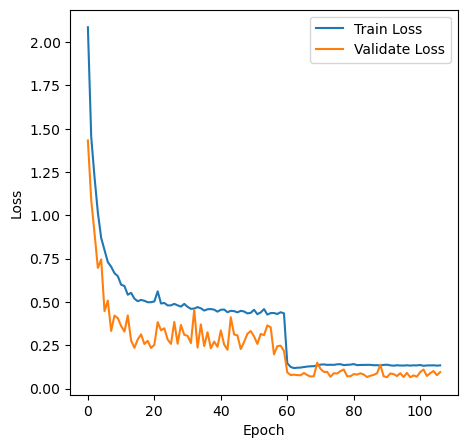

 54%|████████████████████████████████████████▏                                  | 107/200 [7:51:36<6:49:44, 264.35s/it]

Epoch:107
Time:7:56:24.277595
Loss:0.098110538553268
Total:10000  Correct:9710  CleanAccuracy:0.9710


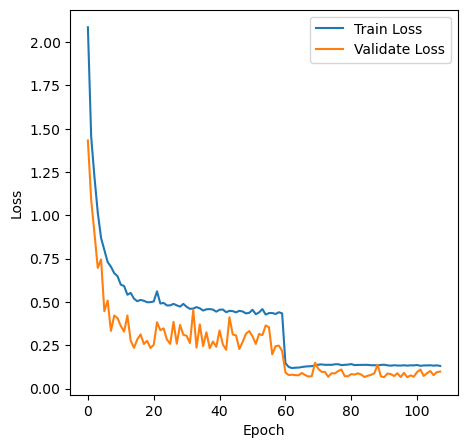

 54%|████████████████████████████████████████▌                                  | 108/200 [7:56:33<7:00:39, 274.35s/it]

Epoch:108
Time:8:00:24.602920
Loss:0.08231040913300713
Total:10000  Correct:9762  CleanAccuracy:0.9762


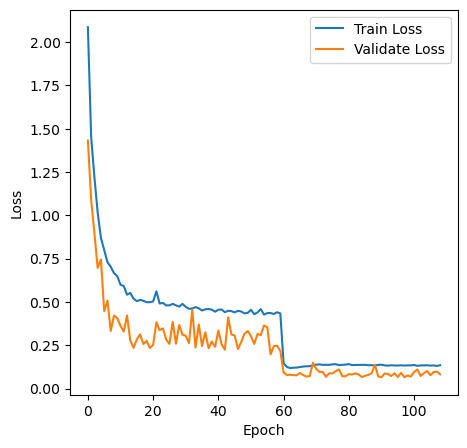

 55%|████████████████████████████████████████▉                                  | 109/200 [8:00:33<6:40:22, 263.99s/it]

Epoch:109
Time:8:04:49.095295
Loss:0.08609872879073642
Total:10000  Correct:9720  CleanAccuracy:0.9720


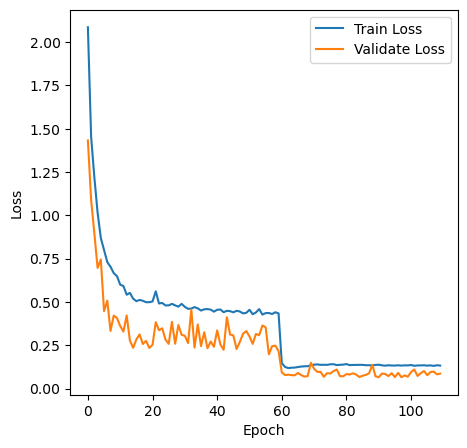

 55%|█████████████████████████████████████████▎                                 | 110/200 [8:04:59<6:36:35, 264.39s/it]

Epoch:110
Time:8:09:20.433681
Loss:0.06274118819352115
Total:10000  Correct:9816  CleanAccuracy:0.9816


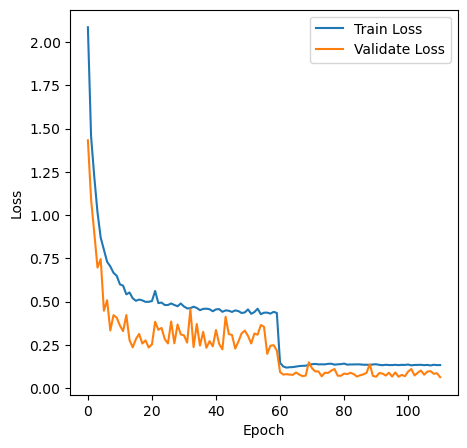

 56%|█████████████████████████████████████████▋                                 | 111/200 [8:09:29<6:34:40, 266.07s/it]

Epoch:111
Time:8:13:43.831744
Loss:0.0622791751409128
Total:10000  Correct:9794  CleanAccuracy:0.9794


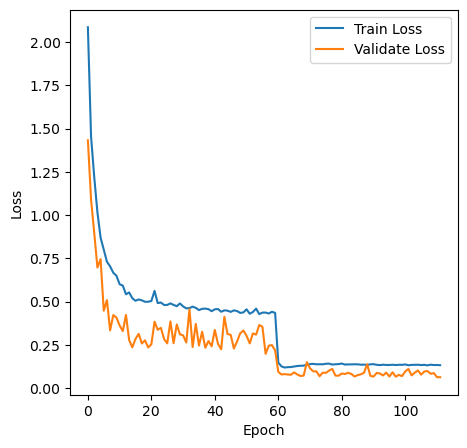

 56%|██████████████████████████████████████████                                 | 112/200 [8:13:53<6:29:37, 265.66s/it]

Epoch:112
Time:8:18:07.073249
Loss:0.07370407762230573
Total:10000  Correct:9751  CleanAccuracy:0.9751


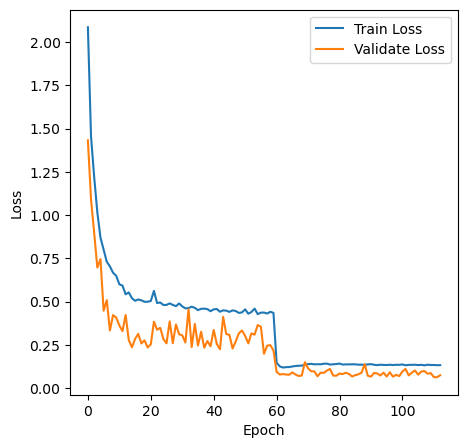

 56%|██████████████████████████████████████████▎                                | 113/200 [8:18:15<6:23:34, 264.54s/it]

Epoch:113
Time:8:22:04.575906
Loss:0.06210517766773879
Total:10000  Correct:9805  CleanAccuracy:0.9805


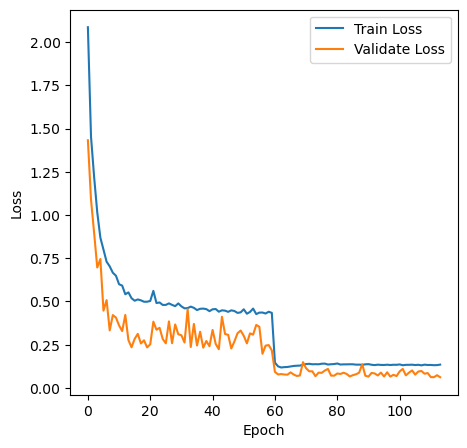

 57%|██████████████████████████████████████████▋                                | 114/200 [8:22:12<6:07:24, 256.33s/it]

Epoch:114
Time:8:26:01.280762
Loss:0.07578522549382748
Total:10000  Correct:9752  CleanAccuracy:0.9752


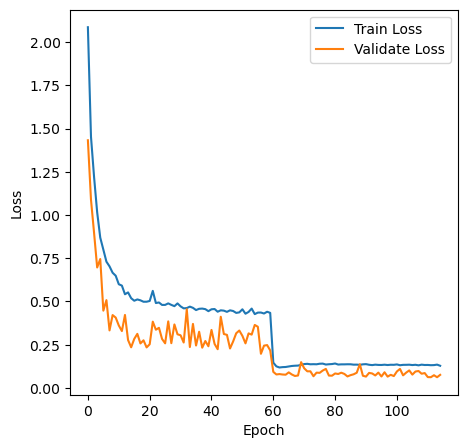

 57%|███████████████████████████████████████████▏                               | 115/200 [8:26:10<5:54:59, 250.58s/it]

Epoch:115
Time:8:29:59.795489
Loss:0.09038355699018799
Total:10000  Correct:9701  CleanAccuracy:0.9701


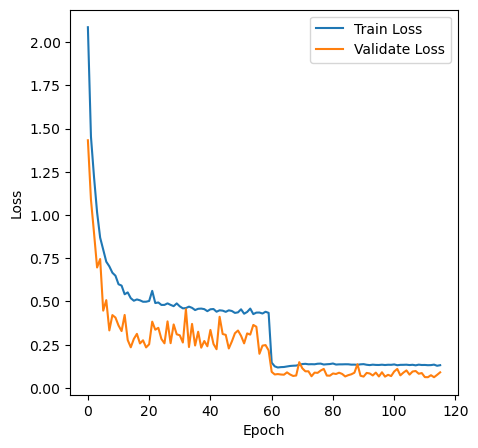

 58%|███████████████████████████████████████████▌                               | 116/200 [8:30:08<5:45:55, 247.09s/it]

Epoch:116
Time:8:34:29.096217
Loss:0.07009320363317566
Total:10000  Correct:9778  CleanAccuracy:0.9778


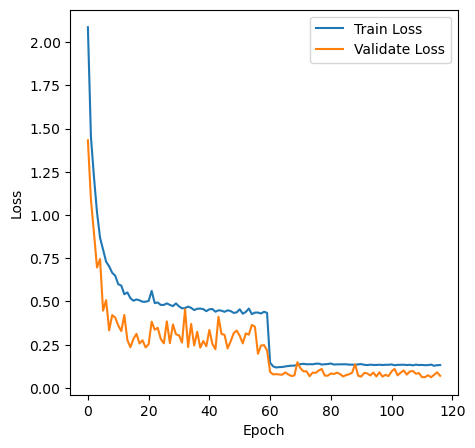

 58%|███████████████████████████████████████████▉                               | 117/200 [8:34:38<5:51:09, 253.86s/it]

Epoch:117
Time:8:38:38.681482
Loss:0.0821851991796152
Total:10000  Correct:9733  CleanAccuracy:0.9733


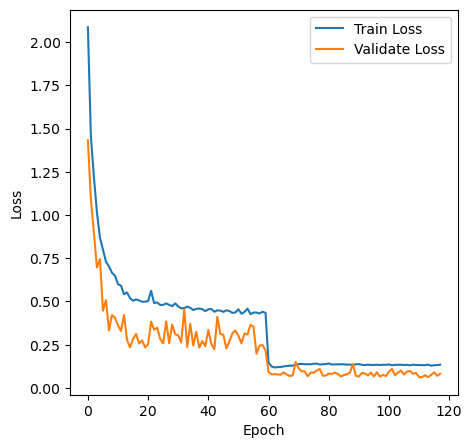

 59%|████████████████████████████████████████████▎                              | 118/200 [8:38:47<5:44:58, 252.42s/it]

Epoch:118
Time:8:42:46.372985
Loss:0.05828916475350876
Total:10000  Correct:9821  CleanAccuracy:0.9821


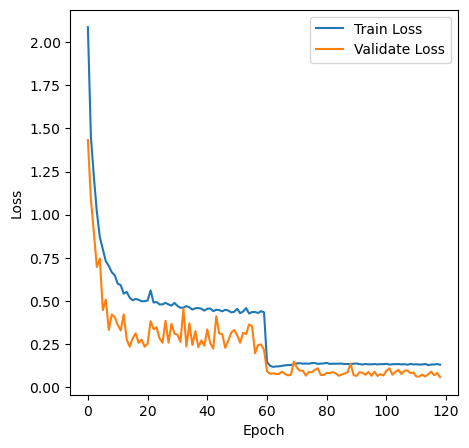

 60%|████████████████████████████████████████████▋                              | 119/200 [8:42:55<5:38:51, 251.01s/it]

Epoch:119
Time:8:47:12.318587
Loss:0.0698559596679343
Total:10000  Correct:9768  CleanAccuracy:0.9768


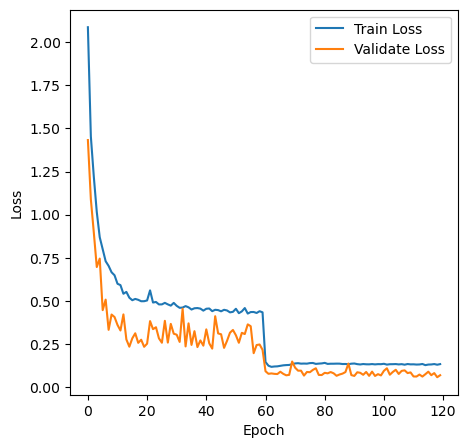

 60%|█████████████████████████████████████████████                              | 120/200 [8:47:21<5:40:40, 255.50s/it]

Epoch:120
Time:8:51:27.098869
Loss:0.043968991276595336
Total:10000  Correct:9861  CleanAccuracy:0.9861


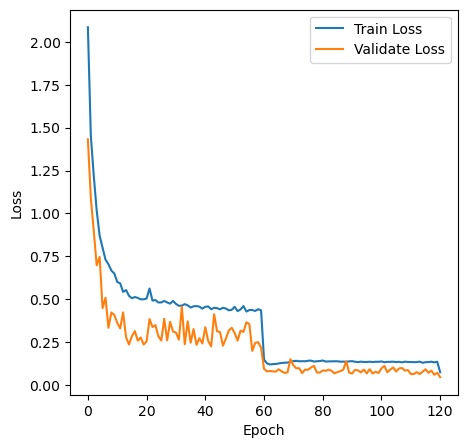

 60%|█████████████████████████████████████████████▍                             | 121/200 [8:51:36<5:36:08, 255.29s/it]

Epoch:121
Time:8:55:38.269551
Loss:0.04207082473176023
Total:10000  Correct:9871  CleanAccuracy:0.9871


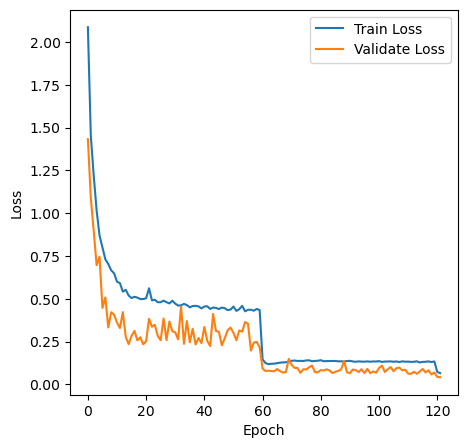

 61%|█████████████████████████████████████████████▊                             | 122/200 [8:55:47<5:30:20, 254.11s/it]

Epoch:122
Time:8:59:50.728568
Loss:0.0423202176521437
Total:10000  Correct:9864  CleanAccuracy:0.9864


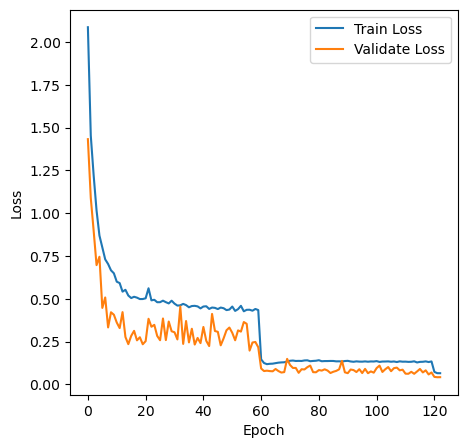

 62%|██████████████████████████████████████████████▏                            | 123/200 [8:59:59<5:25:22, 253.54s/it]

Epoch:123
Time:9:04:02.040259
Loss:0.04607912784828373
Total:10000  Correct:9853  CleanAccuracy:0.9853


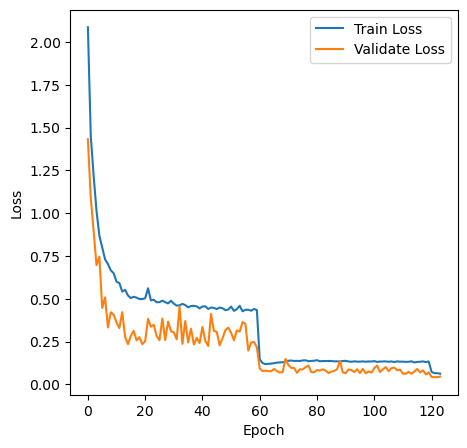

 62%|██████████████████████████████████████████████▌                            | 124/200 [9:04:11<5:20:20, 252.91s/it]

Epoch:124
Time:9:08:14.747754
Loss:0.04148728502936626
Total:10000  Correct:9881  CleanAccuracy:0.9881


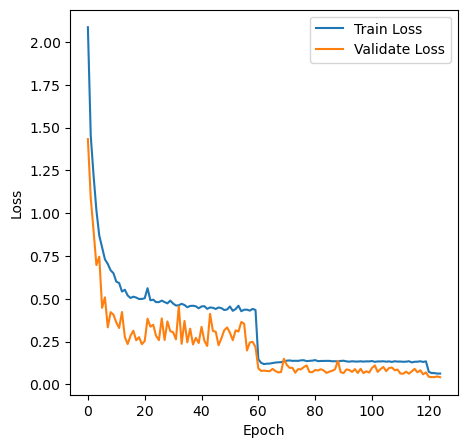

 62%|██████████████████████████████████████████████▉                            | 125/200 [9:08:23<5:16:04, 252.86s/it]

Epoch:125
Time:9:12:26.533326
Loss:0.03981426840732856
Total:10000  Correct:9879  CleanAccuracy:0.9879


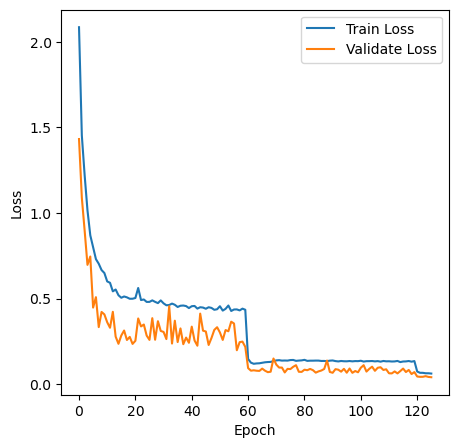

 63%|███████████████████████████████████████████████▎                           | 126/200 [9:12:35<5:11:25, 252.51s/it]

Epoch:126
Time:9:16:39.155294
Loss:0.04242629175471996
Total:10000  Correct:9861  CleanAccuracy:0.9861


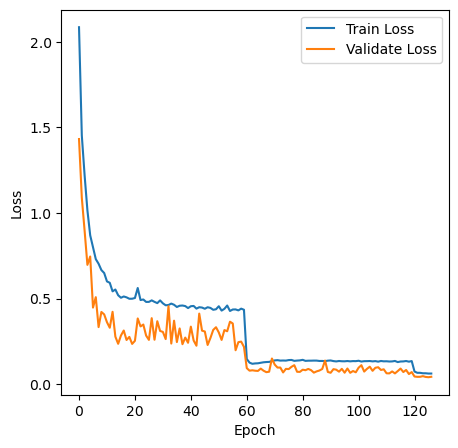

 64%|███████████████████████████████████████████████▋                           | 127/200 [9:16:48<5:07:12, 252.50s/it]

Epoch:127
Time:9:20:50.617323
Loss:0.036556049403396046
Total:10000  Correct:9880  CleanAccuracy:0.9880


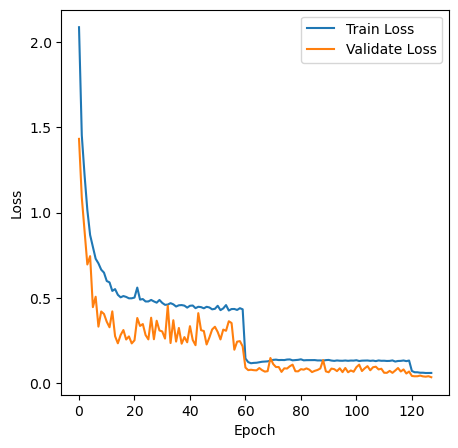

 64%|████████████████████████████████████████████████                           | 128/200 [9:20:58<5:02:23, 252.00s/it]

Epoch:128
Time:9:25:03.065291
Loss:0.044656862810509984
Total:10000  Correct:9868  CleanAccuracy:0.9868


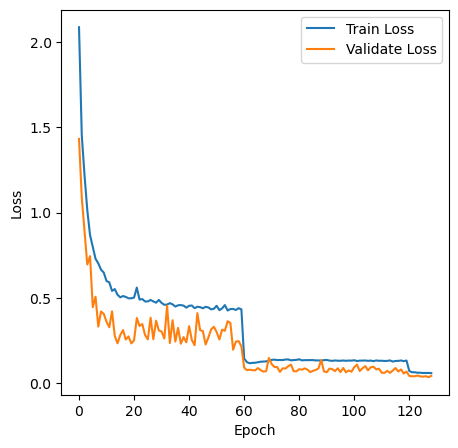

 64%|████████████████████████████████████████████████▍                          | 129/200 [9:25:11<4:58:34, 252.32s/it]

Epoch:129
Time:9:29:15.687860
Loss:0.043232215686047376
Total:10000  Correct:9866  CleanAccuracy:0.9866


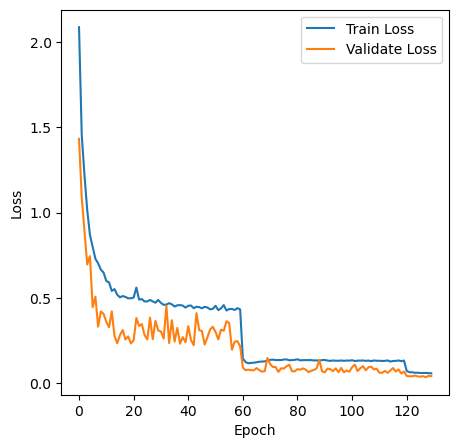

 65%|████████████████████████████████████████████████▊                          | 130/200 [9:29:24<4:54:32, 252.46s/it]

Epoch:130
Time:9:33:28.186041
Loss:0.04301154373504501
Total:10000  Correct:9860  CleanAccuracy:0.9860


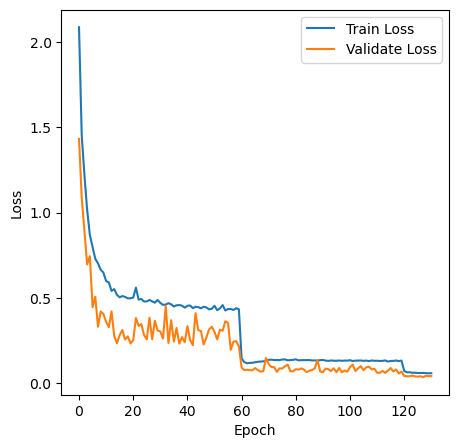

 66%|█████████████████████████████████████████████████▏                         | 131/200 [9:33:36<4:50:13, 252.36s/it]

Epoch:131
Time:9:37:40.722237
Loss:0.03969120787028536
Total:10000  Correct:9873  CleanAccuracy:0.9873


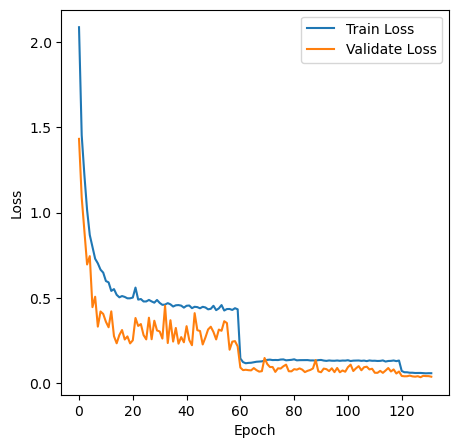

 66%|█████████████████████████████████████████████████▌                         | 132/200 [9:37:49<4:46:11, 252.53s/it]

Epoch:132
Time:9:41:52.535117
Loss:0.04144109976210129
Total:10000  Correct:9877  CleanAccuracy:0.9877


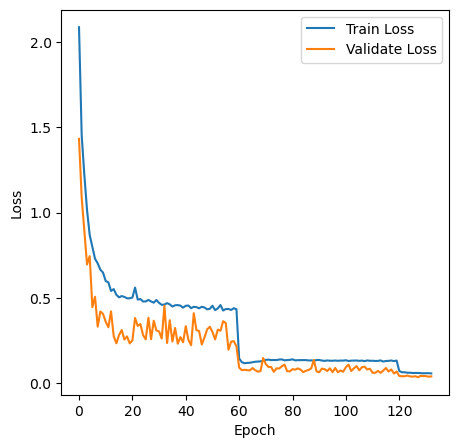

 66%|█████████████████████████████████████████████████▉                         | 133/200 [9:42:01<4:41:44, 252.30s/it]

Epoch:133
Time:9:46:04.341424
Loss:0.038034715402306775
Total:10000  Correct:9882  CleanAccuracy:0.9882


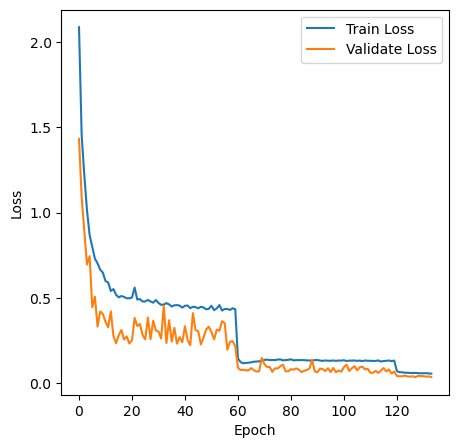

 67%|██████████████████████████████████████████████████▎                        | 134/200 [9:46:13<4:37:19, 252.12s/it]

Epoch:134
Time:9:50:15.966564
Loss:0.04052642016644075
Total:10000  Correct:9872  CleanAccuracy:0.9872


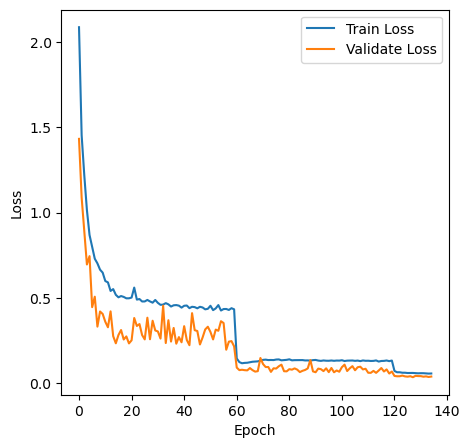

 68%|██████████████████████████████████████████████████▋                        | 135/200 [9:50:24<4:32:57, 251.96s/it]

Epoch:135
Time:9:54:27.023949
Loss:0.03950741336853526
Total:10000  Correct:9872  CleanAccuracy:0.9872


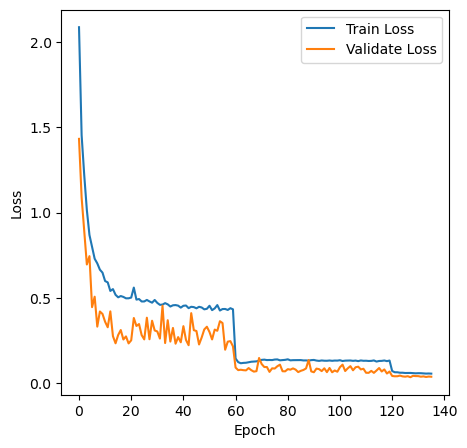

 68%|███████████████████████████████████████████████████                        | 136/200 [9:54:36<4:28:33, 251.77s/it]

Epoch:136
Time:9:58:38.126325
Loss:0.03905980880524719
Total:10000  Correct:9879  CleanAccuracy:0.9879


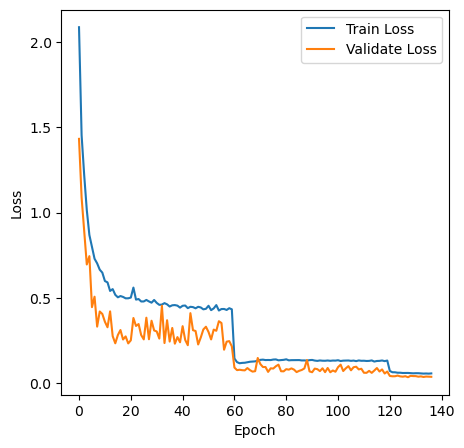

 68%|███████████████████████████████████████████████████▍                       | 137/200 [9:58:47<4:24:09, 251.57s/it]

Epoch:137
Time:10:02:50.594204
Loss:0.04604729129144321
Total:10000  Correct:9854  CleanAccuracy:0.9854


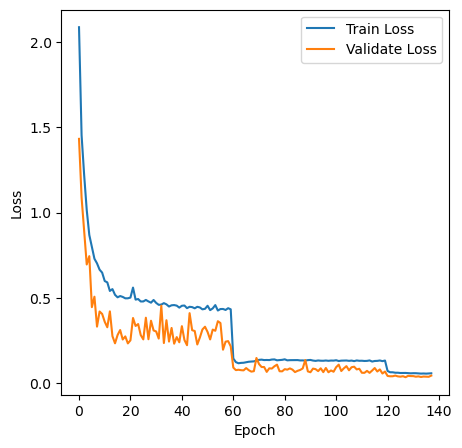

 69%|███████████████████████████████████████████████████                       | 138/200 [10:02:59<4:20:14, 251.85s/it]

Epoch:138
Time:10:07:03.828934
Loss:0.0398322894888262
Total:10000  Correct:9874  CleanAccuracy:0.9874


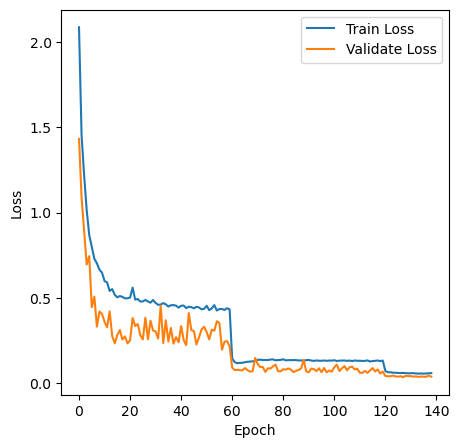

 70%|███████████████████████████████████████████████████▍                      | 139/200 [10:07:12<4:16:26, 252.23s/it]

Epoch:139
Time:10:11:16.931447
Loss:0.03566389005215014
Total:10000  Correct:9883  CleanAccuracy:0.9883


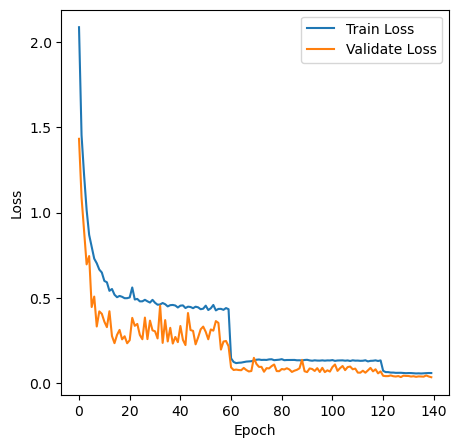

 70%|███████████████████████████████████████████████████▊                      | 140/200 [10:11:25<4:12:23, 252.40s/it]

Epoch:140
Time:10:15:29.893319
Loss:0.03639570829557469
Total:10000  Correct:9887  CleanAccuracy:0.9887


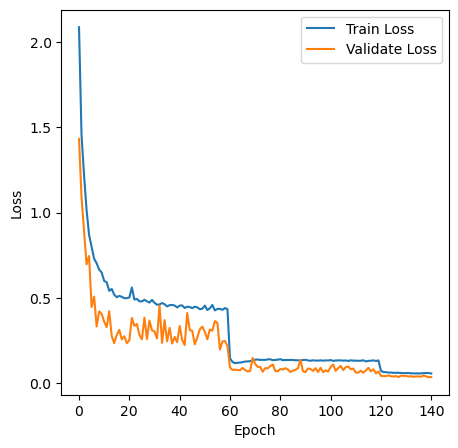

 70%|████████████████████████████████████████████████████▏                     | 141/200 [10:15:39<4:08:27, 252.67s/it]

Epoch:141
Time:10:19:41.440547
Loss:0.043973938388282806
Total:10000  Correct:9865  CleanAccuracy:0.9865


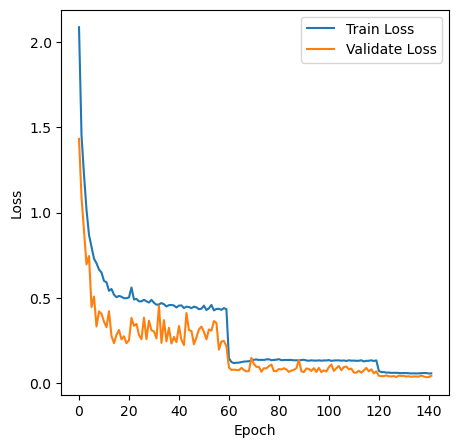

 71%|████████████████████████████████████████████████████▌                     | 142/200 [10:19:50<4:03:53, 252.31s/it]

Epoch:142
Time:10:23:53.407943
Loss:0.04224516209155416
Total:10000  Correct:9868  CleanAccuracy:0.9868


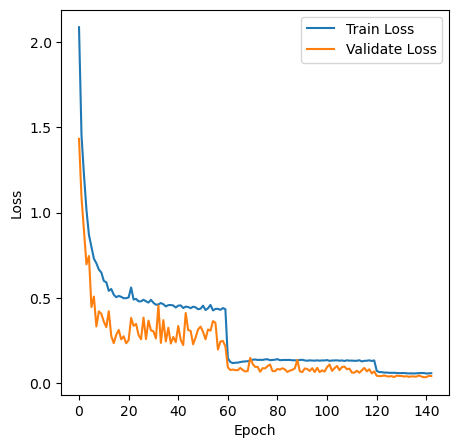

 72%|████████████████████████████████████████████████████▉                     | 143/200 [10:24:02<3:59:34, 252.18s/it]

Epoch:143
Time:10:28:05.600047
Loss:0.039930764183207915
Total:10000  Correct:9873  CleanAccuracy:0.9873


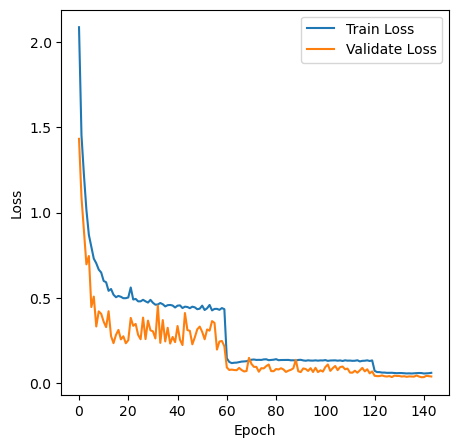

 72%|█████████████████████████████████████████████████████▎                    | 144/200 [10:28:14<3:55:22, 252.19s/it]

Epoch:144
Time:10:32:17.765069
Loss:0.038018608199300086
Total:10000  Correct:9886  CleanAccuracy:0.9886


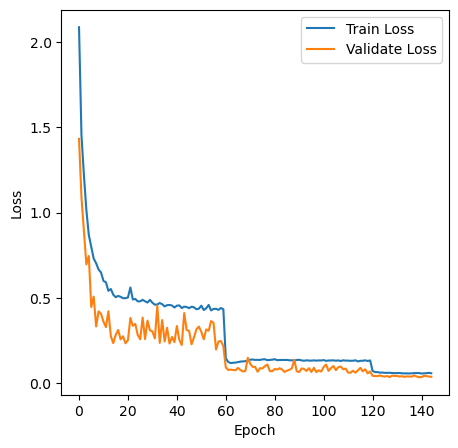

 72%|█████████████████████████████████████████████████████▋                    | 145/200 [10:32:26<3:51:03, 252.06s/it]

Epoch:145
Time:10:36:29.499895
Loss:0.03550997986813439
Total:10000  Correct:9894  CleanAccuracy:0.9894


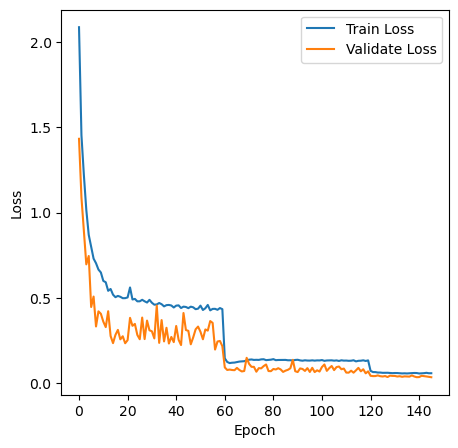

 73%|██████████████████████████████████████████████████████                    | 146/200 [10:36:37<3:46:43, 251.92s/it]

Epoch:146
Time:10:40:41.493812
Loss:0.041733067667096134
Total:10000  Correct:9879  CleanAccuracy:0.9879


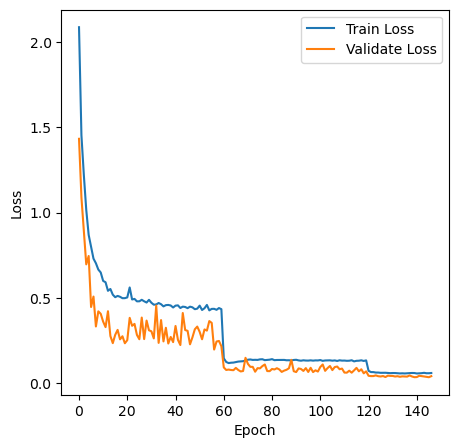

 74%|██████████████████████████████████████████████████████▍                   | 147/200 [10:40:50<3:42:37, 252.02s/it]

Epoch:147
Time:10:44:53.576398
Loss:0.04111907076661121
Total:10000  Correct:9873  CleanAccuracy:0.9873


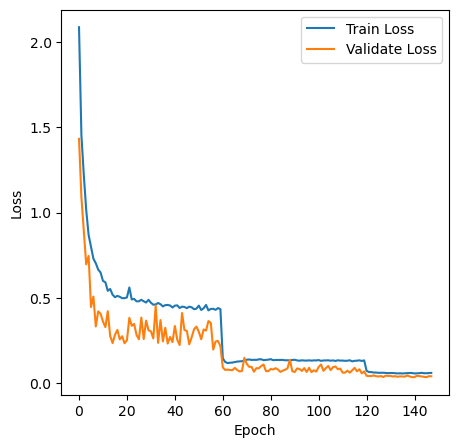

 74%|██████████████████████████████████████████████████████▊                   | 148/200 [10:45:02<3:38:32, 252.16s/it]

Epoch:148
Time:10:49:06.160204
Loss:0.04218766369879954
Total:10000  Correct:9880  CleanAccuracy:0.9880


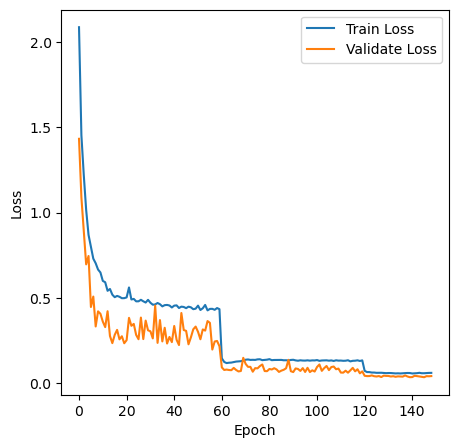

 74%|███████████████████████████████████████████████████████▏                  | 149/200 [10:49:15<3:34:25, 252.26s/it]

Epoch:149
Time:10:53:18.932475
Loss:0.036150353690110944
Total:10000  Correct:9887  CleanAccuracy:0.9887


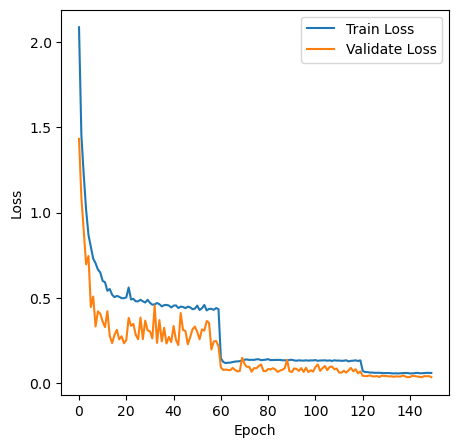

 75%|███████████████████████████████████████████████████████▌                  | 150/200 [10:53:27<3:30:20, 252.42s/it]

Epoch:150
Time:10:57:32.339677
Loss:0.04049053814397164
Total:10000  Correct:9875  CleanAccuracy:0.9875


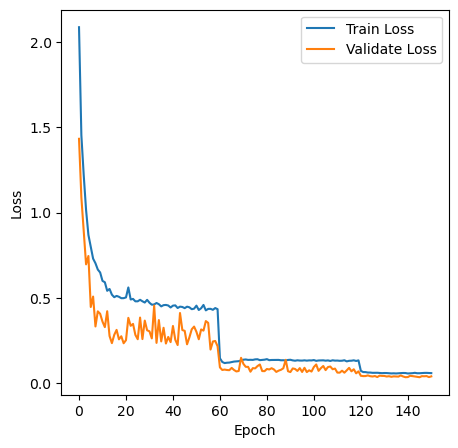

 76%|███████████████████████████████████████████████████████▊                  | 151/200 [10:57:41<3:26:21, 252.69s/it]

Epoch:151
Time:11:01:49.426848
Loss:0.03615427975992511
Total:10000  Correct:9896  CleanAccuracy:0.9896


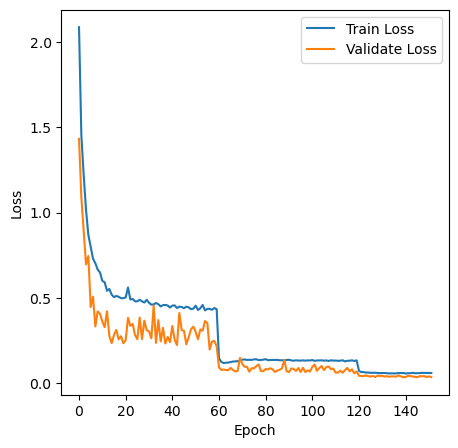

 76%|████████████████████████████████████████████████████████▏                 | 152/200 [11:01:58<3:23:11, 253.98s/it]

Epoch:152
Time:11:05:56.630600
Loss:0.039927763288923224
Total:10000  Correct:9871  CleanAccuracy:0.9871


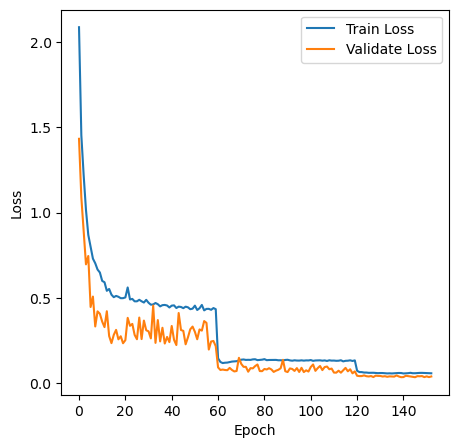

 76%|████████████████████████████████████████████████████████▌                 | 153/200 [11:06:05<3:17:18, 251.89s/it]

Epoch:153
Time:11:09:58.536336
Loss:0.03413695341209322
Total:10000  Correct:9900  CleanAccuracy:0.9900


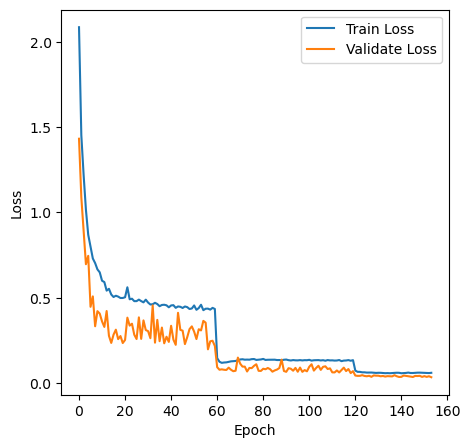

 77%|████████████████████████████████████████████████████████▉                 | 154/200 [11:10:07<3:10:51, 248.95s/it]

Epoch:154
Time:11:14:04.978460
Loss:0.04166256249709332
Total:10000  Correct:9865  CleanAccuracy:0.9865


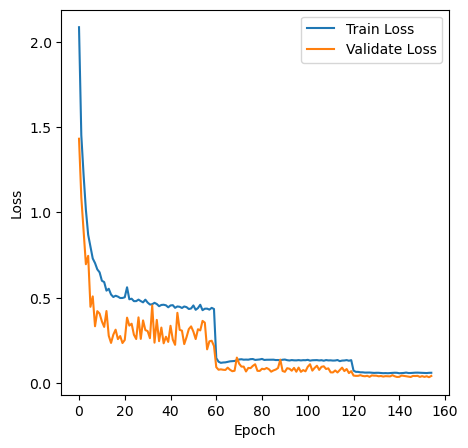

 78%|█████████████████████████████████████████████████████████▎                | 155/200 [11:14:13<3:06:07, 248.17s/it]

Epoch:155
Time:11:18:06.976023
Loss:0.03997832907766577
Total:10000  Correct:9880  CleanAccuracy:0.9880


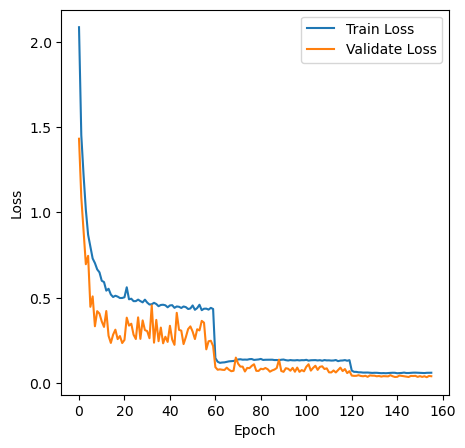

 78%|█████████████████████████████████████████████████████████▋                | 156/200 [11:18:15<3:00:36, 246.28s/it]

Epoch:156
Time:11:22:23.054893
Loss:0.04415271448604867
Total:10000  Correct:9857  CleanAccuracy:0.9857


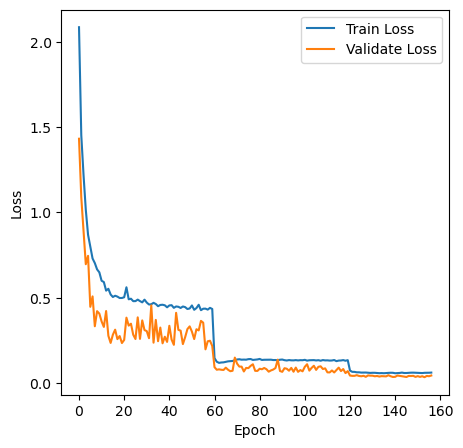

 78%|██████████████████████████████████████████████████████████                | 157/200 [11:22:32<2:58:45, 249.43s/it]

Epoch:157
Time:11:26:38.673967
Loss:0.049715630920081674
Total:10000  Correct:9845  CleanAccuracy:0.9845


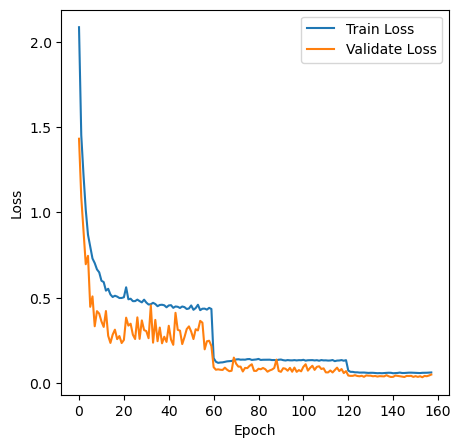

 79%|██████████████████████████████████████████████████████████▍               | 158/200 [11:26:47<2:55:49, 251.18s/it]

Epoch:158
Time:11:30:53.284982
Loss:0.03820193849746495
Total:10000  Correct:9892  CleanAccuracy:0.9892


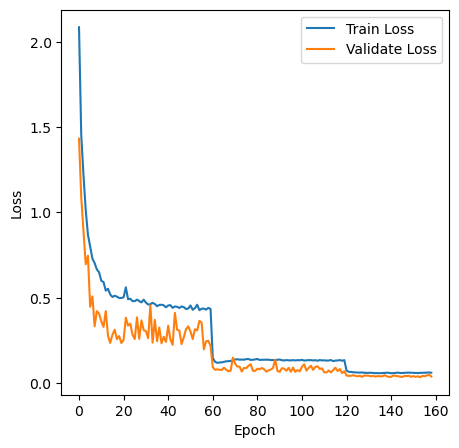

 80%|██████████████████████████████████████████████████████████▊               | 159/200 [11:31:02<2:52:27, 252.37s/it]

Epoch:159
Time:11:35:07.680089
Loss:0.03593295077600266
Total:10000  Correct:9891  CleanAccuracy:0.9891


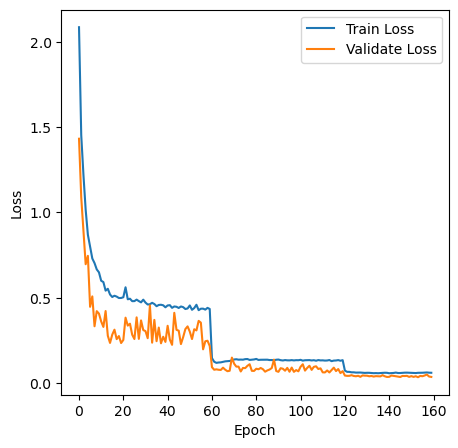

 80%|███████████████████████████████████████████████████████████▏              | 160/200 [11:35:16<2:48:27, 252.69s/it]

Epoch:160
Time:11:39:23.110425
Loss:0.037570173010738124
Total:10000  Correct:9890  CleanAccuracy:0.9890


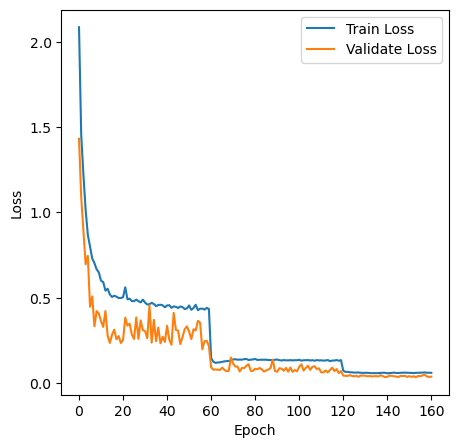

 80%|███████████████████████████████████████████████████████████▌              | 161/200 [11:39:32<2:44:50, 253.61s/it]

Epoch:161
Time:11:43:39.650786
Loss:0.0416259563152534
Total:10000  Correct:9876  CleanAccuracy:0.9876


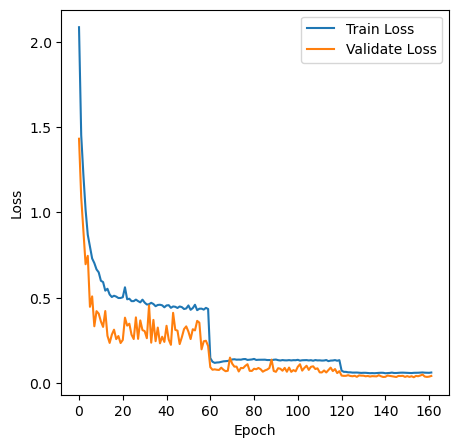

 81%|███████████████████████████████████████████████████████████▉              | 162/200 [11:43:48<2:41:08, 254.44s/it]

Epoch:162
Time:11:47:54.862894
Loss:0.03710525682956254
Total:10000  Correct:9881  CleanAccuracy:0.9881


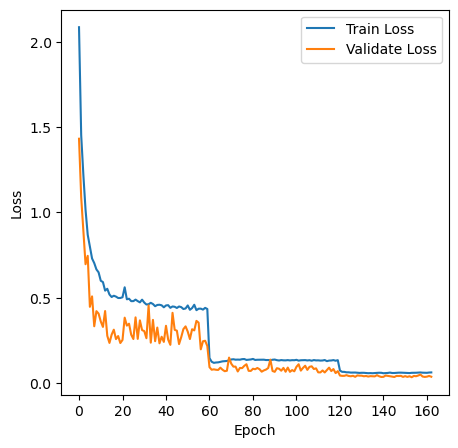

 82%|████████████████████████████████████████████████████████████▎             | 163/200 [11:48:04<2:37:07, 254.81s/it]

Epoch:163
Time:11:52:11.294130
Loss:0.0380759987419065
Total:10000  Correct:9885  CleanAccuracy:0.9885


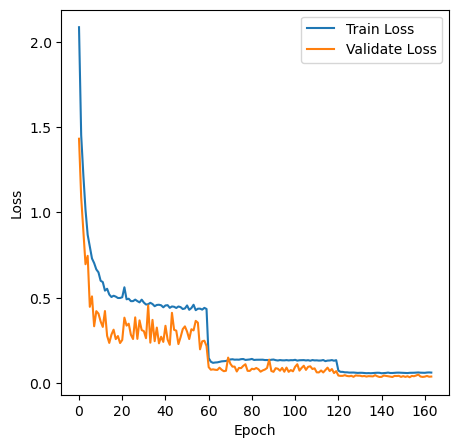

 82%|████████████████████████████████████████████████████████████▋             | 164/200 [11:52:20<2:33:08, 255.24s/it]

Epoch:164
Time:11:56:28.473044
Loss:0.042819456214895295
Total:10000  Correct:9865  CleanAccuracy:0.9865


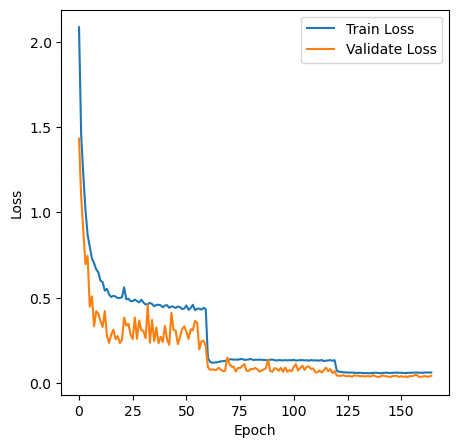

 82%|█████████████████████████████████████████████████████████████             | 165/200 [11:56:37<2:29:13, 255.82s/it]

Epoch:165
Time:12:00:45.153387
Loss:0.04477106711368624
Total:10000  Correct:9847  CleanAccuracy:0.9847


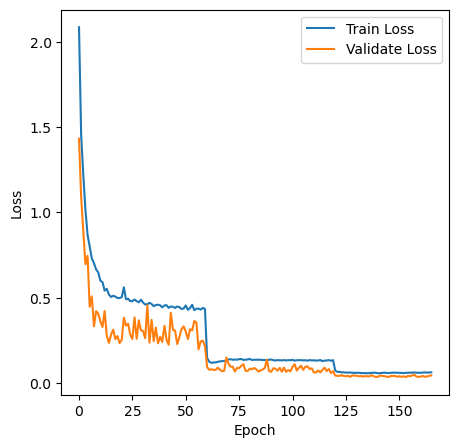

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [12:00:54<2:25:09, 256.17s/it]

Epoch:166
Time:12:05:02.060217
Loss:0.04074905398545397
Total:10000  Correct:9867  CleanAccuracy:0.9867


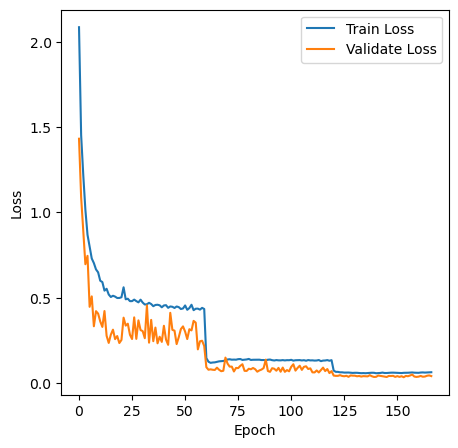

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [12:05:11<2:20:58, 256.30s/it]

Epoch:167
Time:12:09:17.141840
Loss:0.03772965946123926
Total:10000  Correct:9881  CleanAccuracy:0.9881


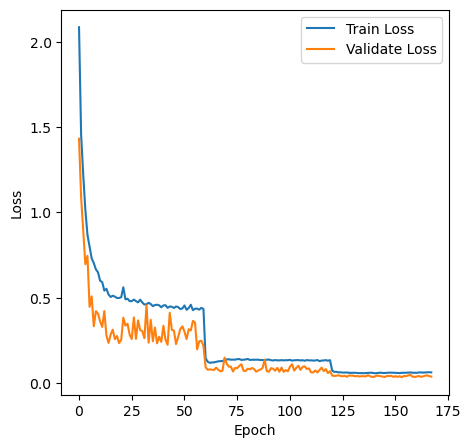

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [12:09:26<2:16:33, 256.05s/it]

Epoch:168
Time:12:13:34.366396
Loss:0.0444511911883309
Total:10000  Correct:9866  CleanAccuracy:0.9866


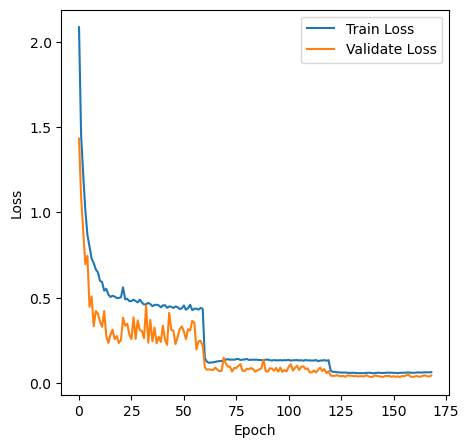

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [12:13:43<2:12:25, 256.32s/it]

Epoch:169
Time:12:17:49.397867
Loss:0.03553732018090246
Total:10000  Correct:9895  CleanAccuracy:0.9895


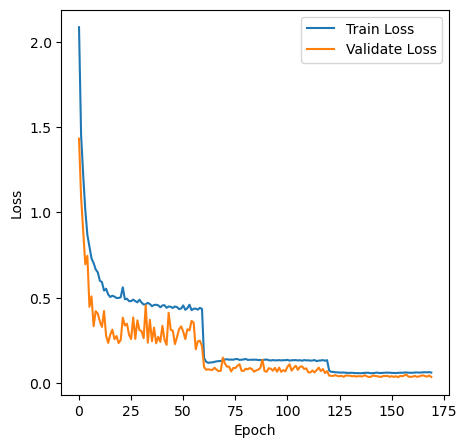

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [12:17:58<2:07:58, 255.94s/it]

Epoch:170
Time:12:22:03.541444
Loss:0.040440449166258934
Total:10000  Correct:9886  CleanAccuracy:0.9886


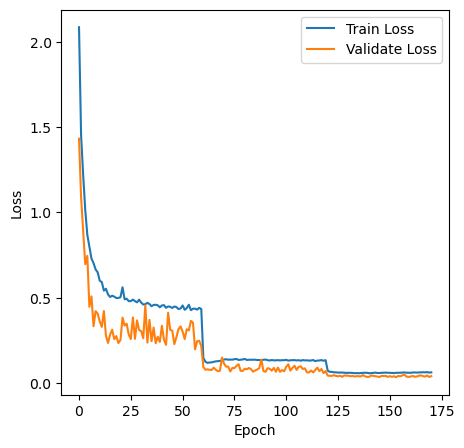

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [12:22:12<2:03:25, 255.36s/it]

Epoch:171
Time:12:26:18.701685
Loss:0.04190003154094527
Total:10000  Correct:9864  CleanAccuracy:0.9864


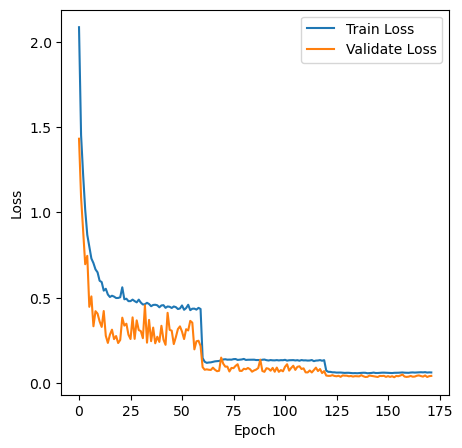

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [12:26:27<1:59:06, 255.22s/it]

Epoch:172
Time:12:30:19.268702
Loss:0.043801562367423705
Total:10000  Correct:9862  CleanAccuracy:0.9862


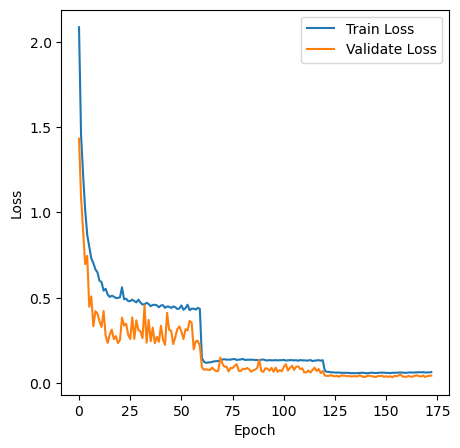

 86%|████████████████████████████████████████████████████████████████          | 173/200 [12:30:28<1:52:53, 250.88s/it]

Epoch:173
Time:12:34:21.353521
Loss:0.03760297099643866
Total:10000  Correct:9891  CleanAccuracy:0.9891


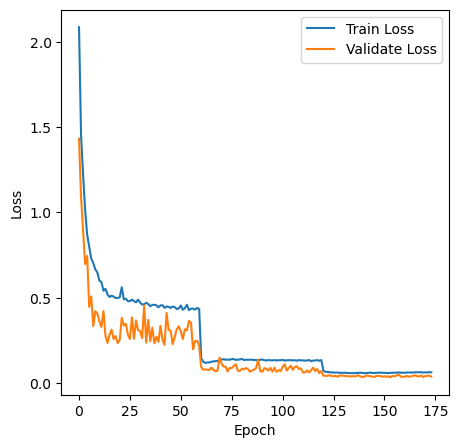

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [12:34:30<1:47:33, 248.20s/it]

Epoch:174
Time:12:38:45.603908
Loss:0.04902461865318406
Total:10000  Correct:9858  CleanAccuracy:0.9858


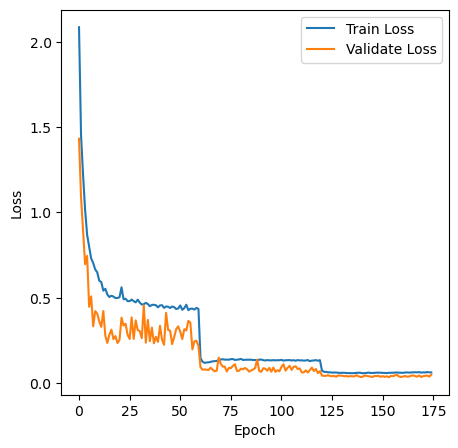

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [12:38:54<1:45:27, 253.08s/it]

Epoch:175
Time:12:42:52.809212
Loss:0.04173925019147547
Total:10000  Correct:9870  CleanAccuracy:0.9870


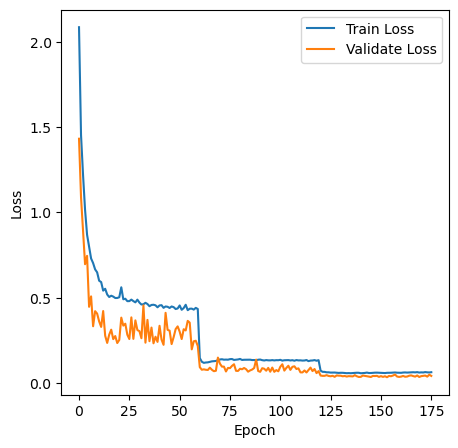

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [12:43:01<1:40:27, 251.16s/it]

Epoch:176
Time:12:47:00.991477
Loss:0.04046298196046842
Total:10000  Correct:9866  CleanAccuracy:0.9866


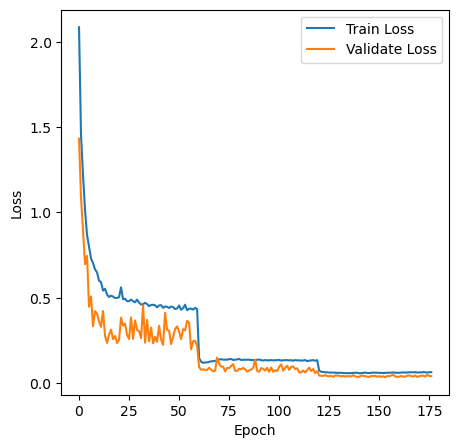

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [12:47:10<1:36:00, 250.47s/it]

Epoch:177
Time:12:51:12.015483
Loss:0.04320948711418273
Total:10000  Correct:9864  CleanAccuracy:0.9864


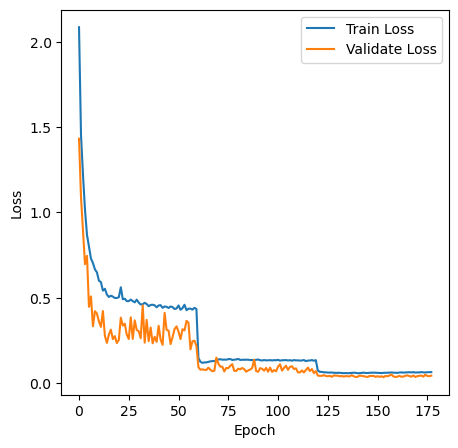

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [12:51:20<1:31:52, 250.55s/it]

Epoch:178
Time:12:55:15.234965
Loss:0.04823826651346272
Total:10000  Correct:9838  CleanAccuracy:0.9838


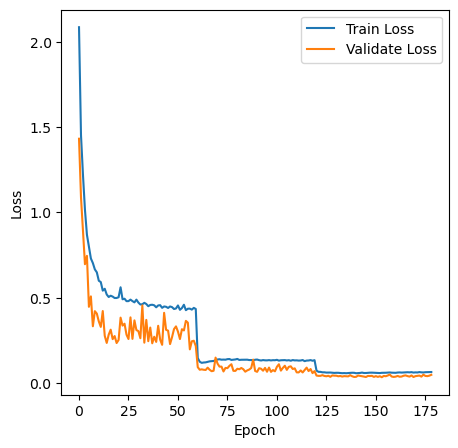

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [12:55:23<1:26:54, 248.30s/it]

Epoch:179
Time:12:59:18.156448
Loss:0.041461709560417295
Total:10000  Correct:9866  CleanAccuracy:0.9866


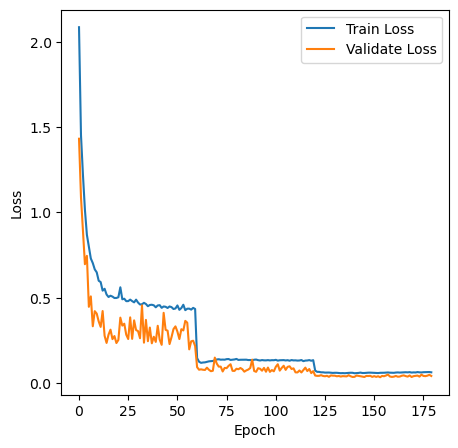

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [12:59:26<1:22:14, 246.72s/it]

Epoch:180
Time:13:03:18.572281
Loss:0.03488391935479449
Total:10000  Correct:9891  CleanAccuracy:0.9891


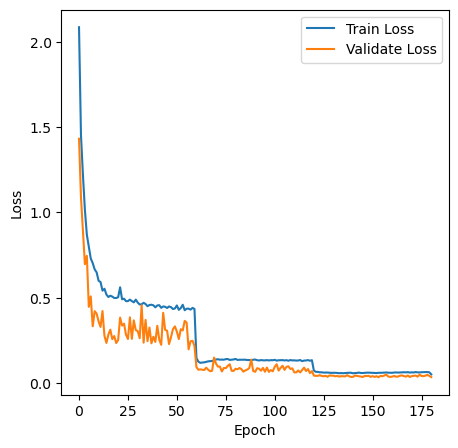

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [13:03:28<1:17:37, 245.12s/it]

Epoch:181
Time:13:07:56.543842
Loss:0.033494472593019235
Total:10000  Correct:9899  CleanAccuracy:0.9899


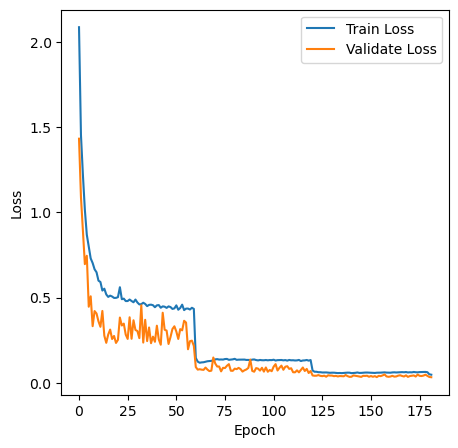

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [13:08:06<1:16:30, 255.03s/it]

Epoch:182
Time:13:12:51.510912
Loss:0.03421545504603889
Total:10000  Correct:9897  CleanAccuracy:0.9897


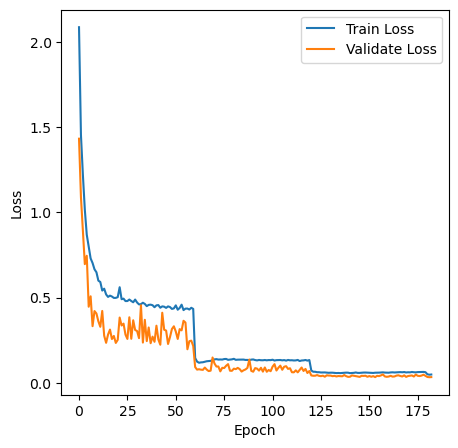

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [13:13:00<1:15:36, 266.86s/it]

Epoch:183
Time:13:17:28.664606
Loss:0.034750500227326155
Total:10000  Correct:9891  CleanAccuracy:0.9891


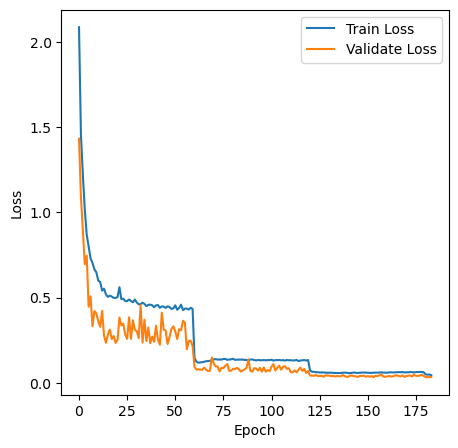

 92%|████████████████████████████████████████████████████████████████████      | 184/200 [13:17:38<1:11:59, 269.96s/it]

Epoch:184
Time:13:22:05.626642
Loss:0.03436004415055151
Total:10000  Correct:9897  CleanAccuracy:0.9897


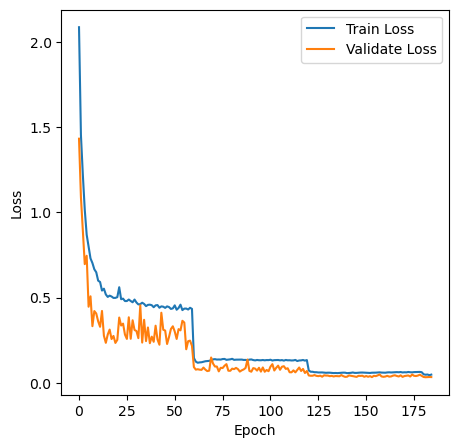

 92%|████████████████████████████████████████████████████████████████████▍     | 185/200 [13:22:15<1:08:00, 272.04s/it]

Epoch:185
Time:13:26:28.833100
Loss:0.03356205705137099
Total:10000  Correct:9901  CleanAccuracy:0.9901


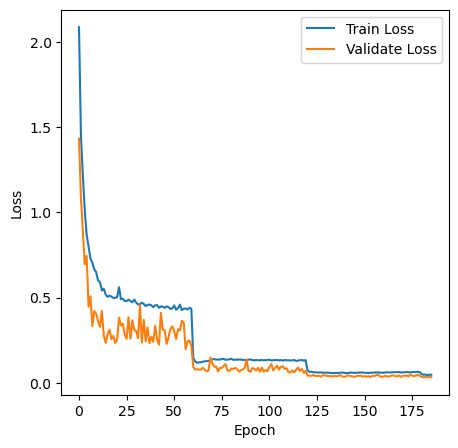

 93%|████████████████████████████████████████████████████████████████████▊     | 186/200 [13:26:38<1:02:51, 269.36s/it]

Epoch:186
Time:13:30:53.194246
Loss:0.032960223314462425
Total:10000  Correct:9896  CleanAccuracy:0.9896


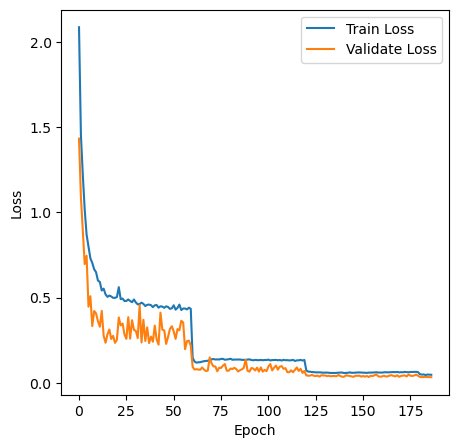

 94%|███████████████████████████████████████████████████████████████████████     | 187/200 [13:31:02<58:01, 267.79s/it]

Epoch:187
Time:13:35:28.046133
Loss:0.033138932234636646
Total:10000  Correct:9905  CleanAccuracy:0.9905


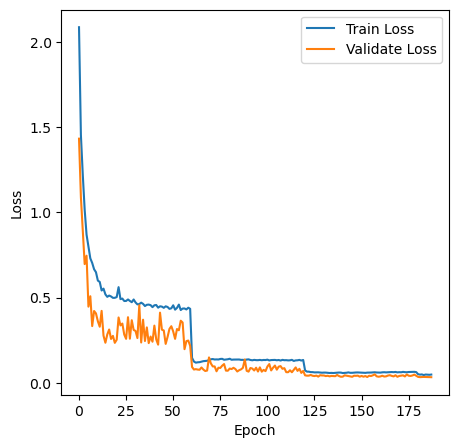

 94%|███████████████████████████████████████████████████████████████████████▍    | 188/200 [13:35:37<53:59, 269.98s/it]

Epoch:188
Time:13:39:59.822835
Loss:0.0339143935953804
Total:10000  Correct:9899  CleanAccuracy:0.9899


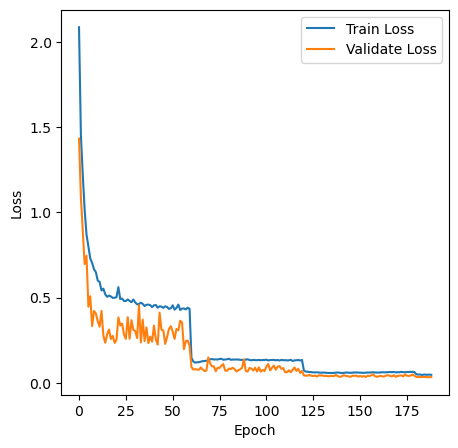

 94%|███████████████████████████████████████████████████████████████████████▊    | 189/200 [13:40:10<49:40, 270.91s/it]

Epoch:189
Time:13:44:31.798090
Loss:0.033840079851725255
Total:10000  Correct:9899  CleanAccuracy:0.9899


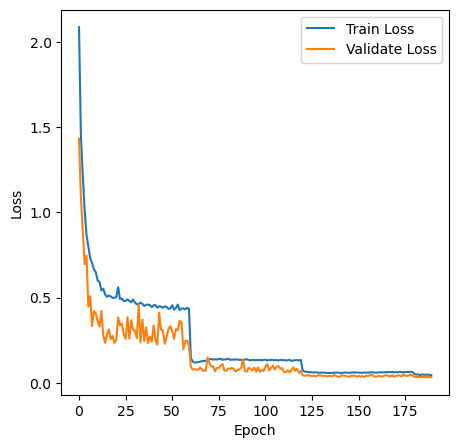

 95%|████████████████████████████████████████████████████████████████████████▏   | 190/200 [13:44:40<45:06, 270.69s/it]

Epoch:190
Time:13:48:46.582439
Loss:0.033778856551857105
Total:10000  Correct:9900  CleanAccuracy:0.9900


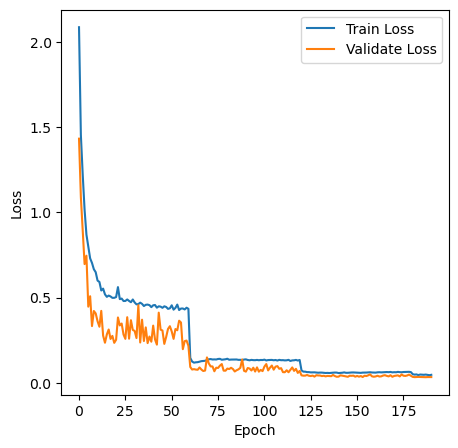

 96%|████████████████████████████████████████████████████████████████████████▌   | 191/200 [13:48:55<39:53, 266.00s/it]

Epoch:191
Time:13:53:33.390806
Loss:0.03330913917602266
Total:10000  Correct:9896  CleanAccuracy:0.9896


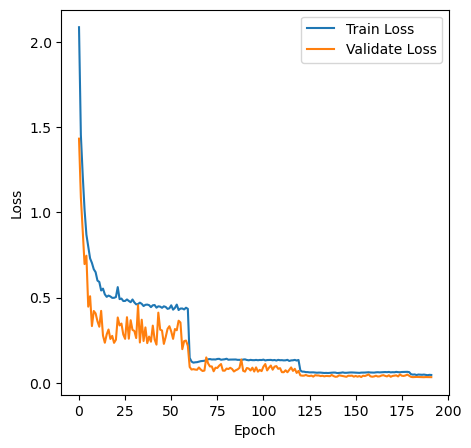

 96%|████████████████████████████████████████████████████████████████████████▉   | 192/200 [13:53:42<36:18, 272.25s/it]

Epoch:192
Time:13:57:59.768113
Loss:0.032634177629593406
Total:10000  Correct:9904  CleanAccuracy:0.9904


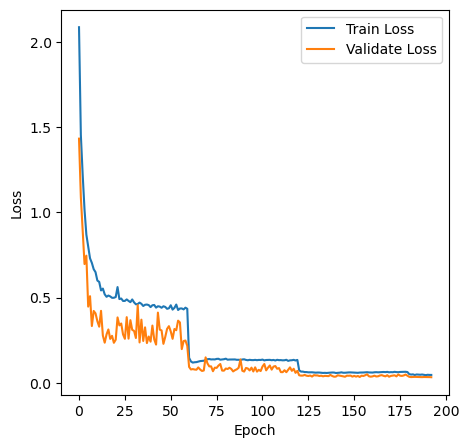

 96%|█████████████████████████████████████████████████████████████████████████▎  | 193/200 [13:58:08<31:33, 270.49s/it]

Epoch:193
Time:14:02:47.213692
Loss:0.03242973066712417
Total:10000  Correct:9900  CleanAccuracy:0.9900


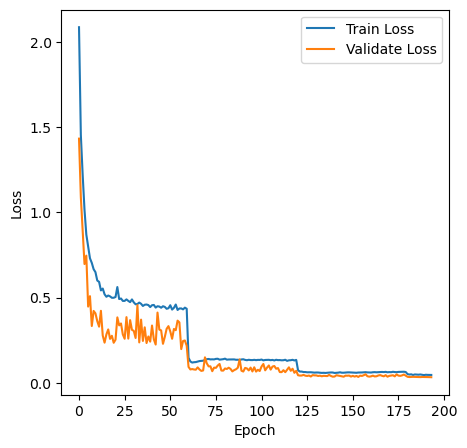

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [14:02:57<27:35, 275.85s/it]

Epoch:194
Time:14:06:58.428051
Loss:0.032874748996438864
Total:10000  Correct:9900  CleanAccuracy:0.9900


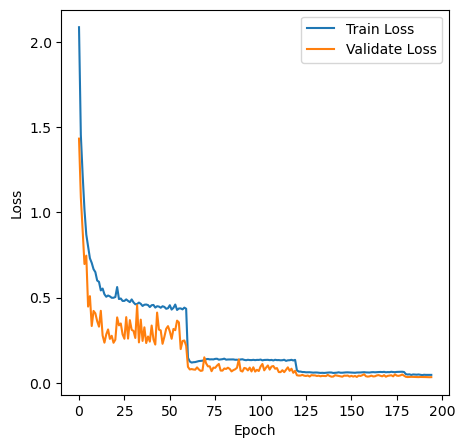

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [14:07:08<22:22, 268.48s/it]

Epoch:195
Time:14:12:01.515967
Loss:0.033589889432456846
Total:10000  Correct:9899  CleanAccuracy:0.9899


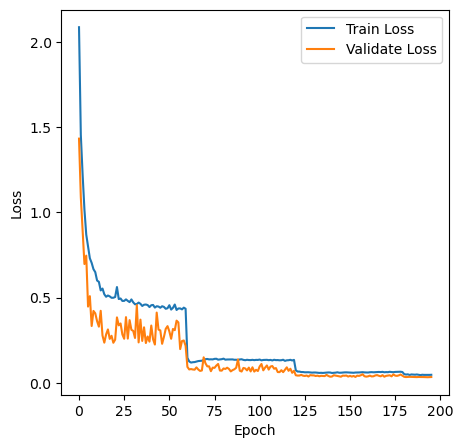

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [14:12:10<18:34, 278.67s/it]

Epoch:196
Time:14:16:54.069664
Loss:0.03510297236673254
Total:10000  Correct:9897  CleanAccuracy:0.9897


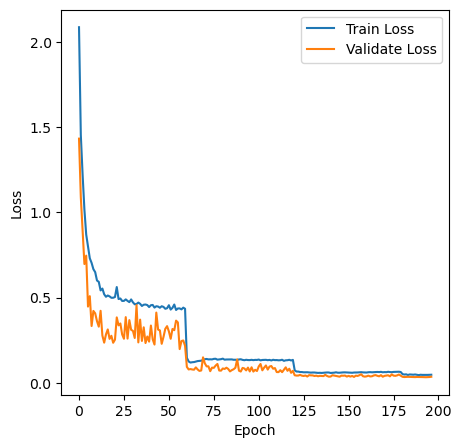

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [14:17:03<14:08, 282.69s/it]

Epoch:197
Time:14:21:20.390047
Loss:0.03297763095741657
Total:10000  Correct:9905  CleanAccuracy:0.9905


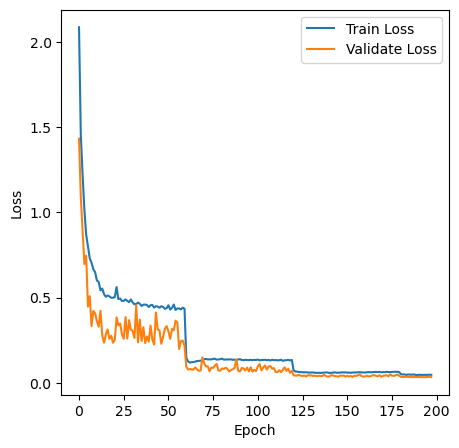

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [14:21:29<09:15, 277.85s/it]

Epoch:198
Time:14:25:38.761835
Loss:0.03307700454219863
Total:10000  Correct:9901  CleanAccuracy:0.9901


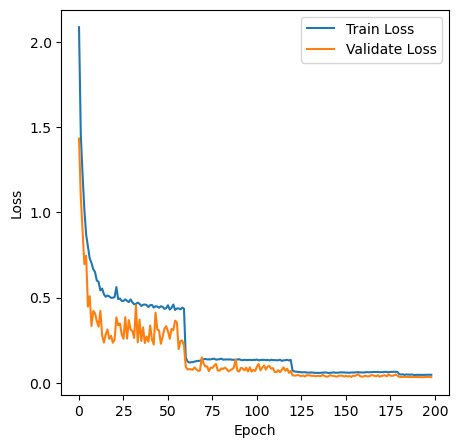

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [14:25:47<04:31, 271.98s/it]

Epoch:199
Time:14:30:31.802872
Loss:0.03127746989492315
Total:10000  Correct:9906  CleanAccuracy:0.9906


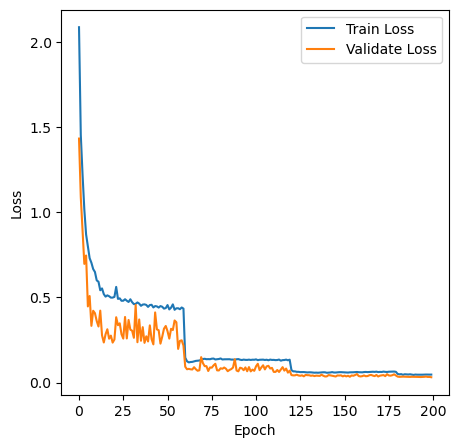

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [14:30:41<00:00, 261.21s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()